<a href="https://colab.research.google.com/github/21020718/KLTN_2025_TrangNTT/blob/main/%5BFinal%5DDataset1_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%autosave 60
import warnings
warnings.filterwarnings('ignore')

Autosaving every 60 seconds


# **Bộ dữ liệu thứ nhất**

# Preprocessing

In [2]:
# Set random seeds for reproducibility
import random
import numpy as np
import torch

# Define a fixed seed value
SEED = 42

# Set random seeds for all libraries
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For GPU if available
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import sklearn.preprocessing
import sklearn.preprocessing._data as data
import sys
sys.modules["sklearn.preprocessing.data"] = data

import pandas as pd
from numpy import concatenate
from math import sqrt

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import normalized_mutual_info_score

def Scaler(data):

    """
        Scaler all feature to range(0,1)
        Arguments:
          data:  Pandas DataFrame of data
        Return:
          scaler: scaler
          scaledDf:Pandas DataFrame of scaled data
    """

    values = data.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(values)
    scaledDf = pd.DataFrame(scaled,columns=data.columns)
    return scaler,scaledDf


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    agg.drop(agg.columns[-(df.shape[1]-1):],axis = 1,inplace=True)
    return agg



if __name__ == '__main__':

    # Load data with date column preserved
    # data = pd.read_csv("/content/drive/MyDrive/KLTN/data/VN2008-2020/VN2008-2020.csv", encoding='utf-8-sig')
    data = pd.read_csv("/content/drive/MyDrive/VN2008-2020.csv", encoding='utf-8-sig')

    # Store dates separately before dropping the column
    dates = data["date"].copy()
    data.drop(columns=["date"], inplace=True)
    data.fillna(0, inplace=True)

    scaler, scaledDf = Scaler(data)

    # Add dates back to scaled data for splitting
    scaledDf_with_dates = scaledDf.copy()
    scaledDf_with_dates['date'] = dates

    # Create time series features
    reframed = series_to_supervised(scaledDf, n_in=12)

    # Add dates back to reframed data (dates correspond to the target time)
    # Since we're using 12 months of history, the date for each row should be the last month in the sequence
    reframed_dates = dates.reset_index(drop=True)
    reframed_with_dates = reframed.copy()
    reframed_with_dates['date'] = reframed_dates

#Build model & Result

##Hybrid

In [ ]:
# # Giảm số lượng/GRU unit, dense unit, epochs và sử dụng batch size nhỏ hơn để huấn luyện nhanh hơn.
# model_types = ['multi-scale']
# lstm_unit = [128, 256, 512]
# gru_unit = [8, 16, 32]
# drop_rate = [0.1, 0.2]
# dense_unit = [16, 32, 64]
# batch_size_num = [2, 4]
# epochs = [100]

model_types = ['hybrid']
lstm_unit = [256,512]
gru_unit = [8,16]
drop_rate = [0.1,0.2]
dense_unit = [32,64]
batch_size_num = [4]
epochs = [100]

# # Replace the current parameter definitions
# model_types = ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble', 'lstm', 'gru']
# lstm_unit = [128]
# gru_unit = [8]
# drop_rate = [0.1]
# dense_unit = [64]
# batch_size_num = [2]
# epochs = [100]

import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class AttentionGRU(nn.Module):
    def __init__(self, input_dim, time_steps, gru_units, dropout_rate, dense_units):
        super(AttentionGRU, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # GRU layer
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(gru_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)
        batch_size = x.size(0)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # GRU layer - output: (batch, seq, hidden_size)
        gru_out, _ = self.gru(attention_mul)

        # Flatten and Dense layers
        flattened = self.flatten(gru_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, dropout_rate, dense_units):
        super(AttentionLSTM, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(lstm_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)
        batch_size = x.size(0)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # LSTM layer - output: (batch, seq, hidden_size)
        lstm_out, _ = self.lstm(attention_mul)

        # Flatten and Dense layers
        flattened = self.flatten(lstm_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class HybridLSTM_GRU(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(HybridLSTM_GRU, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM and GRU layers
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        # Combined size from both LSTM and GRU
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # LSTM and GRU layers
        lstm_out, _ = self.lstm(attention_mul)
        gru_out, _ = self.gru(attention_mul)

        # Concatenate LSTM and GRU outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Flatten and Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class SequentialHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(SequentialHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM followed by GRU
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.gru = nn.GRU(lstm_units, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(gru_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Sequential processing: LSTM then GRU
        lstm_out, _ = self.lstm(attention_mul)
        gru_out, _ = self.gru(lstm_out)

        # Dense layers
        flattened = self.flatten(gru_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class StackedHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(StackedHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Two stacked LSTM layers
        self.lstm1 = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units//2, batch_first=True)

        # Two stacked GRU layers
        self.gru1 = nn.GRU(input_dim, gru_units, batch_first=True)
        self.gru2 = nn.GRU(gru_units, gru_units//2, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units//2 + gru_units//2) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Stacked LSTM path
        lstm_out1, _ = self.lstm1(attention_mul)
        lstm_out2, _ = self.lstm2(lstm_out1)

        # Stacked GRU path
        gru_out1, _ = self.gru1(attention_mul)
        gru_out2, _ = self.gru2(gru_out1)

        # Concatenate final outputs
        combined = torch.cat((lstm_out2, gru_out2), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class BidirectionalHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(BidirectionalHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Bidirectional LSTM and GRU
        self.bilstm = nn.LSTM(input_dim, lstm_units, batch_first=True, bidirectional=True)
        self.bigru = nn.GRU(input_dim, gru_units, batch_first=True, bidirectional=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units*2 + gru_units*2) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Bidirectional networks
        lstm_out, _ = self.bilstm(attention_mul)
        gru_out, _ = self.bigru(attention_mul)

        # Concatenate outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class CNNRNNHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(CNNRNNHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # 1D CNN for feature extraction
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()

        # RNN layers
        self.lstm = nn.LSTM(64, lstm_units, batch_first=True)
        self.gru = nn.GRU(64, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * (time_steps-1), dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # CNN feature extraction
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        cnn_out = self.relu(self.conv1(x))
        cnn_out = self.maxpool(cnn_out)
        cnn_out = self.relu(self.conv2(cnn_out))
        cnn_out = cnn_out.permute(0, 2, 1)  # (batch, seq_len, features)

        # RNN processing
        lstm_out, _ = self.lstm(cnn_out)
        gru_out, _ = self.gru(cnn_out)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class MultiScaleHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(MultiScaleHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # LSTM for long-term dependencies
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)

        # GRU for shorter-term dependencies (operating on windows)
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Attention mechanism
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        # Full sequence for LSTM (long-term)
        lstm_out, _ = self.lstm(x)

        # Attention mechanism for GRU input
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights for GRU (short-term focus)
        gru_input = torch.mul(x, a)
        gru_out, _ = self.gru(gru_input)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class TransformerRNNHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units, nhead=4):
        super(TransformerRNNHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Input projection for transformer
        self.input_proj = nn.Linear(input_dim, 64)

        # Transformer encoder layer
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=nhead, dropout=dropout_rate, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

        # RNN layers
        self.lstm = nn.LSTM(64, lstm_units, batch_first=True)
        self.gru = nn.GRU(64, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Project input to transformer dimension
        x_proj = self.input_proj(x)

        # Apply transformer encoder
        transformer_out = self.transformer_encoder(x_proj)

        # Process with RNNs
        lstm_out, _ = self.lstm(transformer_out)
        gru_out, _ = self.gru(transformer_out)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class EnsembleHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(EnsembleHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Individual models
        self.lstm_model = AttentionLSTM(input_dim, time_steps, lstm_units, dropout_rate, dense_units)
        self.gru_model = AttentionGRU(input_dim, time_steps, gru_units, dropout_rate, dense_units)

        # Combination layer
        self.combine = nn.Linear(2, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Get predictions from each model
        lstm_pred = self.lstm_model(x)
        gru_pred = self.gru_model(x)

        # Combine predictions (learnable weights)
        combined = torch.cat((lstm_pred, gru_pred), dim=1)
        output = self.final_activation(self.combine(combined))

        return output



def build_model(train_X, train_Y, val_X, val_Y, model_type='gru', lstm_units=128, gru_units=128, drop_rate=0.3, dense_unit=64, batch_size=32, epochs=100):
    # Print training parameters
    train_X_tensor = torch.FloatTensor(train_X)
    train_Y_tensor = torch.FloatTensor(train_Y.reshape(-1, 1))
    val_X_tensor = torch.FloatTensor(val_X)
    val_Y_tensor = torch.FloatTensor(val_Y.reshape(-1, 1))

    # Create datasets and dataloaders
    train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
    val_dataset = TensorDataset(val_X_tensor, val_Y_tensor)

    # Create reproducible DataLoaders with fixed seeds
    train_generator = torch.Generator()
    train_generator.manual_seed(SEED)
    val_generator = torch.Generator()
    val_generator.manual_seed(SEED)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=train_generator)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, generator=val_generator)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    time_steps = train_X.shape[1]
    input_dim = train_X.shape[2]

    # Initialize model with fixed initial weights
    torch.manual_seed(SEED)

    if model_type == 'gru':
        model = AttentionGRU(input_dim, time_steps, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'lstm':
        model = AttentionLSTM(input_dim, time_steps, lstm_units, drop_rate, dense_unit).to(device)
    elif model_type == 'hybrid':
        model = HybridLSTM_GRU(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'sequential':
        model = SequentialHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'stacked':
        model = StackedHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'bidirectional':
        model = BidirectionalHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'cnn-rnn':
        model = CNNRNNHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'multi-scale':
        model = MultiScaleHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'transformer-rnn':
        model = TransformerRNNHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'ensemble':
        model = EnsembleHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters())
    criterion = nn.L1Loss()  # MAE loss

    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5
    lr_factor = 0.01

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Print progress
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

        # Learning rate schedule based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= lr_factor
                patience_counter = 0
                print(f'Reducing learning rate by factor of {lr_factor}')

    return model

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mape

def walk_forward(train_X, train_Y, val_X, val_Y, test_X, test_Y, grid_search, scaler):
    r, f, c = test_X.shape
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    all_predictions = {}
    all_adjusted_predictions = {}
    all_ground_truths = {}

    # Create lists to store all evaluation results
    original_valuelists = []
    adjusted_valuelists = []

    for x in grid_search:
        history_x = np.array([x for x in train_X])
        history_y = np.array([y for y in train_Y])
        predictions = list()
        adjusted_predictions = list()
        groundtrue = list()

        # Extract model type first to determine how to unpack the rest
        model_type = x[0]

        # Create the appropriate config_key and extract parameters based on model type
        if model_type in ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble']:
            # Hybrid model has 7 parameters
            model_type, lstm_unit_val, gru_unit_val, drop, dense, batch, epoch = x
            units = f"L{lstm_unit_val}_G{gru_unit_val}"  # For logging
            config_key = f"{model_type}_lstmUnit{lstm_unit_val}_gruUnit{gru_unit_val}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"
        else:
            # LSTM and GRU models have 6 parameters
            model_type, units, drop, dense, batch, epoch = x
            config_key = f"{model_type}_unit{units}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"

        print("\n" + "*"*50)
        print(f"Starting walk-forward validation with parameters:")
        print(f"Model Type: {model_type}, Units: {units}, Dropout: {drop}, Dense Units: {dense}")
        print(f"Batch Size: {batch}, Epochs: {epoch}")
        print(f"Device: {device}")
        print(f"Total test samples: {len(test_X)}")
        print("*"*50 + "\n")

        for i in range(len(test_X)):
            print(f"\nTest iteration {i+1}/{len(test_X)}")
            print(f"Current training set size: {history_x.shape[0]} samples")

            if model_type in ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble']:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                lstm_units=lstm_unit_val, gru_units=gru_unit_val, drop_rate=drop,
                                dense_unit=dense, batch_size=batch, epochs=epoch)
            else:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                lstm_units=units if model_type == 'lstm' else 128,
                                gru_units=units if model_type == 'gru' else 128,
                                drop_rate=drop, dense_unit=dense, batch_size=batch, epochs=epoch)

            # Rest of the function remains the same
            model.eval()

            # Convert test data to tensor
            test_tensor = torch.FloatTensor(test_X[i].reshape(1, f, c)).to(device)

            # Predict
            with torch.no_grad():
                yhat = model(test_tensor).cpu().numpy()

            inv_yhat, inv_y = inverscale(yhat, test_X[i], test_Y[i], scaler)
            prev_month_lockdown = test_X[i][11][5]
            adjusted_inv_yhat = inv_yhat * (1 - prev_month_lockdown)
            predictions.append(inv_yhat)
            adjusted_predictions.append(adjusted_inv_yhat)
            groundtrue.append(inv_y)

            # Observation
            obs_x = test_X[i]
            obs_y = test_Y[i]

            history_x = np.append(history_x, [obs_x], axis=0)
            history_y = np.append(history_y, obs_y)

        # Store predictions and ground truth for this configuration
        all_predictions[config_key] = np.array(predictions).flatten()
        all_adjusted_predictions[config_key] = np.array(adjusted_predictions).flatten()
        all_ground_truths[config_key] = np.array(groundtrue).flatten()

        original_valuelist = evalue(predictions, groundtrue)
        original_valuelist['model_type'] = model_type
        original_valuelist['units'] = units
        original_valuelist['drop_rate'] = drop
        original_valuelist['dense_unit'] = dense
        original_valuelist['batch_size'] = batch
        original_valuelist['epochs'] = epoch

        # Evaluate with adjusted predictions
        adjusted_valuelist = evalue(adjusted_predictions, groundtrue)
        adjusted_valuelist['model_type'] = model_type
        adjusted_valuelist['units'] = units
        adjusted_valuelist['drop_rate'] = drop
        adjusted_valuelist['dense_unit'] = dense
        adjusted_valuelist['batch_size'] = batch
        adjusted_valuelist['epochs'] = epoch

        # Append to the lists of results
        original_valuelists.append(original_valuelist)
        adjusted_valuelists.append(adjusted_valuelist)

    # Combine all results
    all_original_valuelist = pd.concat(original_valuelists, ignore_index=True)
    all_adjusted_valuelist = pd.concat(adjusted_valuelists, ignore_index=True)

    return all_original_valuelist, all_adjusted_valuelist, all_predictions, all_ground_truths, all_adjusted_predictions

def evalue(yhat, inv_y):
    valuelist = {}
    DLM_rmse = sqrt(mean_squared_error(inv_y, yhat))
    valuelist.update({'RMSE': {'DLM': DLM_rmse}})
    DLM_mae = mean_absolute_error(inv_y, yhat)
    valuelist.update({'MAE': {'DLM': DLM_mae}})
    DLM_mape = mean_absolute_percentage_error(inv_y, yhat)
    valuelist.update({'MAPE': {'DLM': DLM_mape}})
    return pd.DataFrame(valuelist)

def inverscale(yhat, test_X, test_Y, scaler):
    feature = len(scaler.scale_)
    test_Y = np.array(test_Y)
    test_X = test_X[1, 0:feature]
    test_X = test_X.reshape(1, test_X.shape[0])

    if len(yhat.shape) == 1:
        yhat = yhat.reshape(len(yhat), 1)

    inv_yhat = concatenate((yhat, test_X[:, :-1]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    test_Y = test_Y.reshape(1, 1)
    inv_y = concatenate((test_Y, test_X[:, :-1]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
    return inv_yhat, inv_y

if __name__ == '__main__':
    values = reframed.values
    reframed_with_dates_values = reframed_with_dates.values

    # Import train_test_split for random splitting
    from sklearn.model_selection import train_test_split

    # Drop the date column for the splitting but keep track of indices
    reframed_without_dates = reframed.copy()

    # First split: 80% train+val, 20% test
    train_val_indices, test_indices = train_test_split(
        np.arange(len(reframed_without_dates)),
        test_size=0.2,
        random_state=SEED
    )

    # Second split: From the 80%, use 7/8 for train (70% of total) and 1/8 for val (10% of total)
    train_indices, val_indices = train_test_split(
        train_val_indices,
        test_size=0.125,  # 0.125 * 0.8 = 0.1 (10% of total)
        random_state=SEED
    )

    # Extract values for train, validation, and test sets
    train_data = reframed.iloc[train_indices].values
    val_data = reframed.iloc[val_indices].values
    test_data = reframed.iloc[test_indices].values

    # Store the corresponding dates for reference
    train_dates = reframed_with_dates.iloc[train_indices]['date']
    val_dates = reframed_with_dates.iloc[val_indices]['date']
    test_dates = reframed_with_dates.iloc[test_indices]['date']

    # Split into X and Y
    train_X, train_Y = train_data[:, :-1], train_data[:, -1]
    val_X, val_Y = val_data[:, :-1], val_data[:, -1]
    test_X, test_Y = test_data[:, :-1], test_data[:, -1]

    # Reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape(train_X.shape[0], 12, int(train_X.shape[1]/12))
    val_X = val_X.reshape(val_X.shape[0], 12, int(val_X.shape[1]/12))
    test_X = test_X.reshape(test_X.shape[0], 12, int(test_X.shape[1]/12))

    # Modified grid search creation for all model types
    grid_search = []
    for model_type in model_types:
        if model_type == 'lstm':
            grid_search.extend(
                list(itertools.product([model_type], lstm_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )
        elif model_type == 'gru':
            grid_search.extend(
                list(itertools.product([model_type], gru_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )
        else:
            # All other models (hybrid, sequential, stacked, etc.) need both LSTM and GRU units
            grid_search.extend(
                list(itertools.product([model_type], lstm_unit, gru_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )

    original_valuelist, adjusted_valuelist, all_predictions, all_ground_truths, all_adjusted_predictions = walk_forward(train_X, train_Y, val_X, val_Y, test_X, test_Y, grid_search, scaler)

    print("Results:")
    print(adjusted_valuelist)

Streaming output truncated to the last 5000 lines.
Epoch 82/100, Train Loss: 0.0380, Val Loss: 0.0398
Epoch 83/100, Train Loss: 0.0376, Val Loss: 0.0398
Reducing learning rate by factor of 0.01
Epoch 84/100, Train Loss: 0.0369, Val Loss: 0.0398
Epoch 85/100, Train Loss: 0.0375, Val Loss: 0.0398
Epoch 86/100, Train Loss: 0.0371, Val Loss: 0.0398
Epoch 87/100, Train Loss: 0.0382, Val Loss: 0.0398
Epoch 88/100, Train Loss: 0.0365, Val Loss: 0.0398
Reducing learning rate by factor of 0.01
Epoch 89/100, Train Loss: 0.0370, Val Loss: 0.0398
Epoch 90/100, Train Loss: 0.0383, Val Loss: 0.0398
Epoch 91/100, Train Loss: 0.0370, Val Loss: 0.0398
Epoch 92/100, Train Loss: 0.0368, Val Loss: 0.0398
Epoch 93/100, Train Loss: 0.0378, Val Loss: 0.0398
Reducing learning rate by factor of 0.01
Epoch 94/100, Train Loss: 0.0376, Val Loss: 0.0398
Epoch 95/100, Train Loss: 0.0369, Val Loss: 0.0398
Epoch 96/100, Train Loss: 0.0376, Val Loss: 0.0398
Epoch 97/100, Train Loss: 0.0389, Val Loss: 0.0398
Epoch 98/1

In [ ]:
adjusted_valuelist

,RMSE,MAE,MAPE,model_type,units,drop_rate,dense_unit,batch_size,epochs
0,249784.188102,118509.607143,17.488050,hybrid,L256_G8,0.1,32,4,100
1,234333.508475,104441.356027,5.870110,hybrid,L256_G8,0.1,64,4,100
2,235183.289575,115937.969866,5.857494,hybrid,L256_G8,0.2,32,4,100
3,245912.508899,103145.171875,6.485597,hybrid,L256_G8,0.2,64,4,100
4,247919.828892,108043.342634,12.699153,hybrid,L256_G16,0.1,32,4,100
5,238335.144596,107060.200893,24.382057,hybrid,L256_G16,0.1,64,4,100
6,238051.025397,112082.593750,8.406826,hybrid,L256_G16,0.2,32,4,100
7,237953.615242,108688.574777,11.245000,hybrid,L256_G16,0.2,64,4,100
8,236853.597343,111330.300223,8.276025,hybrid,L512_G8,0.1,32,4,100
9,232910.681323,102174.939732,8.317327,hybrid,L512_G8,0.1,64,4,100


In [ ]:
all_adjusted_predictions

{'hybrid_lstmUnit256_gruUnit8_drop0.1_dense32_batch4_epochs100': array([      0.  ,  663497.3 ,  467259.1 , 1330277.  ,  591774.7 ,
         416874.5 ,  588709.8 ,  699454.8 , 1355296.8 ,  619002.7 ,
        1245848.2 , 1438250.2 ,  619844.94,  416420.2 ,  796438.75,
         613419.4 ,  400426.78,  451312.84, 1602284.1 , 1172899.6 ,
         553084.25, 1312636.1 ,  603316.5 ,  414175.16,  677476.3 ,
         473814.56, 1658738.  ,  765384.94], dtype=float32),
 'hybrid_lstmUnit256_gruUnit8_drop0.1_dense64_batch4_epochs100': array([      0.  ,  597886.6 ,  486088.3 , 1410906.  ,  532848.1 ,
         406753.1 ,  593534.94,  559717.8 , 1362451.6 ,  594334.4 ,
        1217381.8 , 1494933.5 ,  635722.4 ,  430412.12,  738596.75,
         641263.25,  383769.97,  452027.6 , 1579113.6 , 1354288.2 ,
         577189.8 , 1322430.1 ,  606942.4 ,  374071.88,  646270.94,
         461265.  , 1728911.2 ,  750296.1 ], dtype=float32),
 'hybrid_lstmUnit256_gruUnit8_drop0.2_dense32_batch4_epochs100': array

In [ ]:
all_ground_truths

{'hybrid_lstmUnit256_gruUnit8_drop0.1_dense32_batch4_epochs100': array([      0. ,  564736. ,  552234. , 1301909. ,  466000. ,  416249. ,
         613919. ,  590881. , 1315792. ,  676719. , 1161114. , 1809580. ,
         626324. ,  427935. ,  830608. ,  559002. ,  376400. ,  460000. ,
         449923. , 1431845. ,  630000. , 1205157. ,  593566. ,  292843. ,
         756000. ,  475733. , 1994124.9,  776174. ], dtype=float32),
 'hybrid_lstmUnit256_gruUnit8_drop0.1_dense64_batch4_epochs100': array([      0. ,  564736. ,  552234. , 1301909. ,  466000. ,  416249. ,
         613919. ,  590881. , 1315792. ,  676719. , 1161114. , 1809580. ,
         626324. ,  427935. ,  830608. ,  559002. ,  376400. ,  460000. ,
         449923. , 1431845. ,  630000. , 1205157. ,  593566. ,  292843. ,
         756000. ,  475733. , 1994124.9,  776174. ], dtype=float32),
 'hybrid_lstmUnit256_gruUnit8_drop0.2_dense32_batch4_epochs100': array([      0. ,  564736. ,  552234. , 1301909. ,  466000. ,  416249. ,
    

In [ ]:
adjusted_valuelist.to_csv( '/content/drive/MyDrive/HybridLSTMGRU_random.csv', index=False)
pd.DataFrame(all_adjusted_predictions).to_csv("/content/drive/MyDrive/all_adjusted_predictions_random.csv", index=False)
pd.DataFrame(all_ground_truths).to_csv("/content/drive/MyDrive/all_ground_truths_random.csv", index=False)

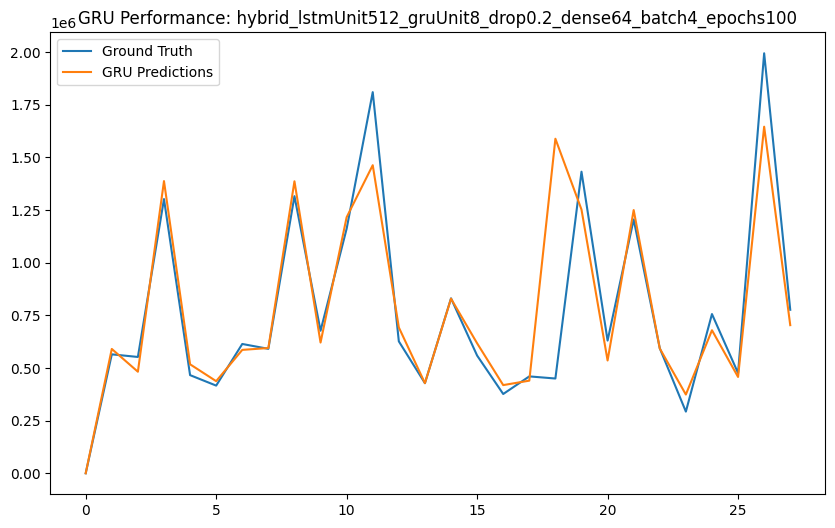

In [ ]:
config_key = 'hybrid_lstmUnit512_gruUnit8_drop0.2_dense64_batch4_epochs100'
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(all_ground_truths[config_key], label='Ground Truth')
plt.plot(all_adjusted_predictions[config_key], label='GRU Predictions')
plt.title(f'GRU Performance: {config_key}')
plt.legend()
plt.show()

##GRU

In [ ]:
# # Giảm số lượng/GRU unit, dense unit, epochs và sử dụng batch size nhỏ hơn để huấn luyện nhanh hơn.
# model_types = ['multi-scale']
# lstm_unit = [128, 256, 512]
# gru_unit = [8, 16, 32]
# drop_rate = [0.1, 0.2]
# dense_unit = [16, 32, 64]
# batch_size_num = [2, 4]
# epochs = [100]

model_types = ['gru']
lstm_unit = [256,512]
gru_unit = [8,16]
drop_rate = [0.1,0.2]
dense_unit = [32,64]
batch_size_num = [4]
epochs = [100]

# # Replace the current parameter definitions
# model_types = ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble', 'lstm', 'gru']
# lstm_unit = [128]
# gru_unit = [8]
# drop_rate = [0.1]
# dense_unit = [64]
# batch_size_num = [2]
# epochs = [100]

import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class AttentionGRU(nn.Module):
    def __init__(self, input_dim, time_steps, gru_units, dropout_rate, dense_units):
        super(AttentionGRU, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # GRU layer
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(gru_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)
        batch_size = x.size(0)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # GRU layer - output: (batch, seq, hidden_size)
        gru_out, _ = self.gru(attention_mul)

        # Flatten and Dense layers
        flattened = self.flatten(gru_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, dropout_rate, dense_units):
        super(AttentionLSTM, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(lstm_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)
        batch_size = x.size(0)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # LSTM layer - output: (batch, seq, hidden_size)
        lstm_out, _ = self.lstm(attention_mul)

        # Flatten and Dense layers
        flattened = self.flatten(lstm_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class HybridLSTM_GRU(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(HybridLSTM_GRU, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM and GRU layers
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        # Combined size from both LSTM and GRU
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # LSTM and GRU layers
        lstm_out, _ = self.lstm(attention_mul)
        gru_out, _ = self.gru(attention_mul)

        # Concatenate LSTM and GRU outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Flatten and Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class SequentialHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(SequentialHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM followed by GRU
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.gru = nn.GRU(lstm_units, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(gru_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Sequential processing: LSTM then GRU
        lstm_out, _ = self.lstm(attention_mul)
        gru_out, _ = self.gru(lstm_out)

        # Dense layers
        flattened = self.flatten(gru_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class StackedHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(StackedHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Two stacked LSTM layers
        self.lstm1 = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units//2, batch_first=True)

        # Two stacked GRU layers
        self.gru1 = nn.GRU(input_dim, gru_units, batch_first=True)
        self.gru2 = nn.GRU(gru_units, gru_units//2, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units//2 + gru_units//2) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Stacked LSTM path
        lstm_out1, _ = self.lstm1(attention_mul)
        lstm_out2, _ = self.lstm2(lstm_out1)

        # Stacked GRU path
        gru_out1, _ = self.gru1(attention_mul)
        gru_out2, _ = self.gru2(gru_out1)

        # Concatenate final outputs
        combined = torch.cat((lstm_out2, gru_out2), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class BidirectionalHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(BidirectionalHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Bidirectional LSTM and GRU
        self.bilstm = nn.LSTM(input_dim, lstm_units, batch_first=True, bidirectional=True)
        self.bigru = nn.GRU(input_dim, gru_units, batch_first=True, bidirectional=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units*2 + gru_units*2) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Bidirectional networks
        lstm_out, _ = self.bilstm(attention_mul)
        gru_out, _ = self.bigru(attention_mul)

        # Concatenate outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class CNNRNNHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(CNNRNNHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # 1D CNN for feature extraction
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()

        # RNN layers
        self.lstm = nn.LSTM(64, lstm_units, batch_first=True)
        self.gru = nn.GRU(64, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * (time_steps-1), dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # CNN feature extraction
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        cnn_out = self.relu(self.conv1(x))
        cnn_out = self.maxpool(cnn_out)
        cnn_out = self.relu(self.conv2(cnn_out))
        cnn_out = cnn_out.permute(0, 2, 1)  # (batch, seq_len, features)

        # RNN processing
        lstm_out, _ = self.lstm(cnn_out)
        gru_out, _ = self.gru(cnn_out)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class MultiScaleHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(MultiScaleHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # LSTM for long-term dependencies
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)

        # GRU for shorter-term dependencies (operating on windows)
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Attention mechanism
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        # Full sequence for LSTM (long-term)
        lstm_out, _ = self.lstm(x)

        # Attention mechanism for GRU input
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights for GRU (short-term focus)
        gru_input = torch.mul(x, a)
        gru_out, _ = self.gru(gru_input)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class TransformerRNNHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units, nhead=4):
        super(TransformerRNNHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Input projection for transformer
        self.input_proj = nn.Linear(input_dim, 64)

        # Transformer encoder layer
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=nhead, dropout=dropout_rate, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

        # RNN layers
        self.lstm = nn.LSTM(64, lstm_units, batch_first=True)
        self.gru = nn.GRU(64, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Project input to transformer dimension
        x_proj = self.input_proj(x)

        # Apply transformer encoder
        transformer_out = self.transformer_encoder(x_proj)

        # Process with RNNs
        lstm_out, _ = self.lstm(transformer_out)
        gru_out, _ = self.gru(transformer_out)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class EnsembleHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(EnsembleHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Individual models
        self.lstm_model = AttentionLSTM(input_dim, time_steps, lstm_units, dropout_rate, dense_units)
        self.gru_model = AttentionGRU(input_dim, time_steps, gru_units, dropout_rate, dense_units)

        # Combination layer
        self.combine = nn.Linear(2, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Get predictions from each model
        lstm_pred = self.lstm_model(x)
        gru_pred = self.gru_model(x)

        # Combine predictions (learnable weights)
        combined = torch.cat((lstm_pred, gru_pred), dim=1)
        output = self.final_activation(self.combine(combined))

        return output



def build_model(train_X, train_Y, val_X, val_Y, model_type='gru', lstm_units=128, gru_units=128, drop_rate=0.3, dense_unit=64, batch_size=32, epochs=100):
    # Print training parameters
    train_X_tensor = torch.FloatTensor(train_X)
    train_Y_tensor = torch.FloatTensor(train_Y.reshape(-1, 1))
    val_X_tensor = torch.FloatTensor(val_X)
    val_Y_tensor = torch.FloatTensor(val_Y.reshape(-1, 1))

    # Create datasets and dataloaders
    train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
    val_dataset = TensorDataset(val_X_tensor, val_Y_tensor)

    # Create reproducible DataLoaders with fixed seeds
    train_generator = torch.Generator()
    train_generator.manual_seed(SEED)
    val_generator = torch.Generator()
    val_generator.manual_seed(SEED)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=train_generator)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, generator=val_generator)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    time_steps = train_X.shape[1]
    input_dim = train_X.shape[2]

    # Initialize model with fixed initial weights
    torch.manual_seed(SEED)

    if model_type == 'gru':
        model = AttentionGRU(input_dim, time_steps, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'lstm':
        model = AttentionLSTM(input_dim, time_steps, lstm_units, drop_rate, dense_unit).to(device)
    elif model_type == 'hybrid':
        model = HybridLSTM_GRU(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'sequential':
        model = SequentialHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'stacked':
        model = StackedHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'bidirectional':
        model = BidirectionalHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'cnn-rnn':
        model = CNNRNNHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'multi-scale':
        model = MultiScaleHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'transformer-rnn':
        model = TransformerRNNHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'ensemble':
        model = EnsembleHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters())
    criterion = nn.L1Loss()  # MAE loss

    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5
    lr_factor = 0.01

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Print progress
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

        # Learning rate schedule based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= lr_factor
                patience_counter = 0
                print(f'Reducing learning rate by factor of {lr_factor}')

    return model

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mape

def walk_forward(train_X, train_Y, val_X, val_Y, test_X, test_Y, grid_search, scaler):
    r, f, c = test_X.shape
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    all_predictions = {}
    all_adjusted_predictions = {}
    all_ground_truths = {}

    # Create lists to store all evaluation results
    original_valuelists = []
    adjusted_valuelists = []

    for x in grid_search:
        history_x = np.array([x for x in train_X])
        history_y = np.array([y for y in train_Y])
        predictions = list()
        adjusted_predictions = list()
        groundtrue = list()

        # Extract model type first to determine how to unpack the rest
        model_type = x[0]

        # Create the appropriate config_key and extract parameters based on model type
        if model_type in ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble']:
            # Hybrid model has 7 parameters
            model_type, lstm_unit_val, gru_unit_val, drop, dense, batch, epoch = x
            units = f"L{lstm_unit_val}_G{gru_unit_val}"  # For logging
            config_key = f"{model_type}_lstmUnit{lstm_unit_val}_gruUnit{gru_unit_val}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"
        else:
            # LSTM and GRU models have 6 parameters
            model_type, units, drop, dense, batch, epoch = x
            config_key = f"{model_type}_unit{units}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"

        print("\n" + "*"*50)
        print(f"Starting walk-forward validation with parameters:")
        print(f"Model Type: {model_type}, Units: {units}, Dropout: {drop}, Dense Units: {dense}")
        print(f"Batch Size: {batch}, Epochs: {epoch}")
        print(f"Device: {device}")
        print(f"Total test samples: {len(test_X)}")
        print("*"*50 + "\n")

        for i in range(len(test_X)):
            print(f"\nTest iteration {i+1}/{len(test_X)}")
            print(f"Current training set size: {history_x.shape[0]} samples")

            if model_type in ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble']:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                lstm_units=lstm_unit_val, gru_units=gru_unit_val, drop_rate=drop,
                                dense_unit=dense, batch_size=batch, epochs=epoch)
            else:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                lstm_units=units if model_type == 'lstm' else 128,
                                gru_units=units if model_type == 'gru' else 128,
                                drop_rate=drop, dense_unit=dense, batch_size=batch, epochs=epoch)

            # Rest of the function remains the same
            model.eval()

            # Convert test data to tensor
            test_tensor = torch.FloatTensor(test_X[i].reshape(1, f, c)).to(device)

            # Predict
            with torch.no_grad():
                yhat = model(test_tensor).cpu().numpy()

            inv_yhat, inv_y = inverscale(yhat, test_X[i], test_Y[i], scaler)
            prev_month_lockdown = test_X[i][11][5]
            adjusted_inv_yhat = inv_yhat * (1 - prev_month_lockdown)
            predictions.append(inv_yhat)
            adjusted_predictions.append(adjusted_inv_yhat)
            groundtrue.append(inv_y)

            # Observation
            obs_x = test_X[i]
            obs_y = test_Y[i]

            history_x = np.append(history_x, [obs_x], axis=0)
            history_y = np.append(history_y, obs_y)

        # Store predictions and ground truth for this configuration
        all_predictions[config_key] = np.array(predictions).flatten()
        all_adjusted_predictions[config_key] = np.array(adjusted_predictions).flatten()
        all_ground_truths[config_key] = np.array(groundtrue).flatten()

        original_valuelist = evalue(predictions, groundtrue)
        original_valuelist['model_type'] = model_type
        original_valuelist['units'] = units
        original_valuelist['drop_rate'] = drop
        original_valuelist['dense_unit'] = dense
        original_valuelist['batch_size'] = batch
        original_valuelist['epochs'] = epoch

        # Evaluate with adjusted predictions
        adjusted_valuelist = evalue(adjusted_predictions, groundtrue)
        adjusted_valuelist['model_type'] = model_type
        adjusted_valuelist['units'] = units
        adjusted_valuelist['drop_rate'] = drop
        adjusted_valuelist['dense_unit'] = dense
        adjusted_valuelist['batch_size'] = batch
        adjusted_valuelist['epochs'] = epoch

        # Append to the lists of results
        original_valuelists.append(original_valuelist)
        adjusted_valuelists.append(adjusted_valuelist)

    # Combine all results
    all_original_valuelist = pd.concat(original_valuelists, ignore_index=True)
    all_adjusted_valuelist = pd.concat(adjusted_valuelists, ignore_index=True)

    return all_original_valuelist, all_adjusted_valuelist, all_predictions, all_ground_truths, all_adjusted_predictions

def evalue(yhat, inv_y):
    valuelist = {}
    DLM_rmse = sqrt(mean_squared_error(inv_y, yhat))
    valuelist.update({'RMSE': {'DLM': DLM_rmse}})
    DLM_mae = mean_absolute_error(inv_y, yhat)
    valuelist.update({'MAE': {'DLM': DLM_mae}})
    DLM_mape = mean_absolute_percentage_error(inv_y, yhat)
    valuelist.update({'MAPE': {'DLM': DLM_mape}})
    return pd.DataFrame(valuelist)

def inverscale(yhat, test_X, test_Y, scaler):
    feature = len(scaler.scale_)
    test_Y = np.array(test_Y)
    test_X = test_X[1, 0:feature]
    test_X = test_X.reshape(1, test_X.shape[0])

    if len(yhat.shape) == 1:
        yhat = yhat.reshape(len(yhat), 1)

    inv_yhat = concatenate((yhat, test_X[:, :-1]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    test_Y = test_Y.reshape(1, 1)
    inv_y = concatenate((test_Y, test_X[:, :-1]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
    return inv_yhat, inv_y

if __name__ == '__main__':
    values = reframed.values
    reframed_with_dates_values = reframed_with_dates.values

    # Import train_test_split for random splitting
    from sklearn.model_selection import train_test_split

    # Drop the date column for the splitting but keep track of indices
    reframed_without_dates = reframed.copy()

    # First split: 80% train+val, 20% test
    train_val_indices, test_indices = train_test_split(
        np.arange(len(reframed_without_dates)),
        test_size=0.2,
        random_state=SEED
    )

    # Second split: From the 80%, use 7/8 for train (70% of total) and 1/8 for val (10% of total)
    train_indices, val_indices = train_test_split(
        train_val_indices,
        test_size=0.125,  # 0.125 * 0.8 = 0.1 (10% of total)
        random_state=SEED
    )

    # Extract values for train, validation, and test sets
    train_data = reframed.iloc[train_indices].values
    val_data = reframed.iloc[val_indices].values
    test_data = reframed.iloc[test_indices].values

    # Store the corresponding dates for reference
    train_dates = reframed_with_dates.iloc[train_indices]['date']
    val_dates = reframed_with_dates.iloc[val_indices]['date']
    test_dates = reframed_with_dates.iloc[test_indices]['date']

    # Split into X and Y
    train_X, train_Y = train_data[:, :-1], train_data[:, -1]
    val_X, val_Y = val_data[:, :-1], val_data[:, -1]
    test_X, test_Y = test_data[:, :-1], test_data[:, -1]

    # Reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape(train_X.shape[0], 12, int(train_X.shape[1]/12))
    val_X = val_X.reshape(val_X.shape[0], 12, int(val_X.shape[1]/12))
    test_X = test_X.reshape(test_X.shape[0], 12, int(test_X.shape[1]/12))

    # Modified grid search creation for all model types
    grid_search = []
    for model_type in model_types:
        if model_type == 'lstm':
            grid_search.extend(
                list(itertools.product([model_type], lstm_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )
        elif model_type == 'gru':
            grid_search.extend(
                list(itertools.product([model_type], gru_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )
        else:
            # All other models (hybrid, sequential, stacked, etc.) need both LSTM and GRU units
            grid_search.extend(
                list(itertools.product([model_type], lstm_unit, gru_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )

    original_valuelist, adjusted_valuelist, all_predictions, all_ground_truths, all_adjusted_predictions = walk_forward(train_X, train_Y, val_X, val_Y, test_X, test_Y, grid_search, scaler)

    # Group results by model type
    # gru_results = adjusted_valuelist[adjusted_valuelist['model_type'] == 'gru']
    # lstm_results = adjusted_valuelist[adjusted_valuelist['model_type'] == 'lstm']

    print("Results:")
    print(adjusted_valuelist)

Streaming output truncated to the last 5000 lines.
Epoch 68/100, Train Loss: 0.0609, Val Loss: 0.0432
Epoch 69/100, Train Loss: 0.0601, Val Loss: 0.0432
Reducing learning rate by factor of 0.01
Epoch 70/100, Train Loss: 0.0612, Val Loss: 0.0432
Epoch 71/100, Train Loss: 0.0620, Val Loss: 0.0432
Epoch 72/100, Train Loss: 0.0609, Val Loss: 0.0432
Epoch 73/100, Train Loss: 0.0621, Val Loss: 0.0432
Epoch 74/100, Train Loss: 0.0617, Val Loss: 0.0432
Reducing learning rate by factor of 0.01
Epoch 75/100, Train Loss: 0.0621, Val Loss: 0.0432
Epoch 76/100, Train Loss: 0.0614, Val Loss: 0.0432
Epoch 77/100, Train Loss: 0.0621, Val Loss: 0.0432
Epoch 78/100, Train Loss: 0.0635, Val Loss: 0.0432
Epoch 79/100, Train Loss: 0.0617, Val Loss: 0.0432
Reducing learning rate by factor of 0.01
Epoch 80/100, Train Loss: 0.0610, Val Loss: 0.0432
Epoch 81/100, Train Loss: 0.0634, Val Loss: 0.0432
Epoch 82/100, Train Loss: 0.0633, Val Loss: 0.0432
Epoch 83/100, Train Loss: 0.0613, Val Loss: 0.0432
Epoch 84/1

In [ ]:
adjusted_valuelist.to_csv( '/content/drive/MyDrive/GRU_random.csv', index=False)
pd.DataFrame(all_adjusted_predictions).to_csv("/content/drive/MyDrive/all_adjusted_predictions_GRU_random.csv", index=False)
pd.DataFrame(all_ground_truths).to_csv("/content/drive/MyDrive/all_ground_truths_GRU_random.csv", index=False)

In [ ]:
adjusted_valuelist

,RMSE,MAE,MAPE,model_type,units,drop_rate,dense_unit,batch_size,epochs
0,246224.854561,131556.025670,14.706872,gru,8,0.1,32,4,100
1,251255.446773,133765.324777,4.758086,gru,8,0.1,64,4,100
2,242925.981965,134619.986607,22.945423,gru,8,0.2,32,4,100
3,251446.799289,137708.970982,19.582800,gru,8,0.2,64,4,100
4,243101.926192,129849.833705,23.511106,gru,16,0.1,32,4,100
5,244154.166413,125539.046875,18.763624,gru,16,0.1,64,4,100
6,247750.635084,129658.975446,21.587090,gru,16,0.2,32,4,100
7,248808.993662,121571.821429,9.699997,gru,16,0.2,64,4,100


In [ ]:
all_adjusted_predictions

{'gru_unit8_drop0.1_dense32_batch4_epochs100': array([      0.  ,  647791.  ,  394569.38, 1314448.4 ,  550984.3 ,
         410702.03,  572928.4 ,  666221.9 , 1368073.  ,  640821.56,
        1207034.9 , 1442079.  ,  664889.9 ,  436922.8 ,  730164.3 ,
         648040.  ,  414720.7 ,  414929.34, 1490724.2 , 1271937.4 ,
         442434.12, 1268360.1 ,  623061.5 ,  412776.8 ,  627524.44,
         422915.4 , 1447373.6 ,  703705.7 ], dtype=float32),
 'gru_unit8_drop0.1_dense64_batch4_epochs100': array([      0.  ,  591606.6 ,  418470.2 , 1287424.6 ,  569016.5 ,
         388727.2 ,  561687.8 ,  572062.1 , 1347292.2 ,  614513.56,
        1226774.8 , 1416928.9 ,  690049.9 ,  448817.03,  751976.4 ,
         605348.1 ,  436730.6 ,  414276.12, 1526023.6 , 1223477.5 ,
         478004.94, 1287703.2 ,  678106.94,  407717.62,  608032.94,
         432986.97, 1472487.  ,  705885.75], dtype=float32),
 'gru_unit8_drop0.2_dense32_batch4_epochs100': array([      0.  ,  694317.06,  426255.9 , 1339773.  ,  563

In [ ]:
all_ground_truths

{'gru_unit8_drop0.1_dense32_batch4_epochs100': array([      0. ,  564736. ,  552234. , 1301909. ,  466000. ,  416249. ,
         613919. ,  590881. , 1315792. ,  676719. , 1161114. , 1809580. ,
         626324. ,  427935. ,  830608. ,  559002. ,  376400. ,  460000. ,
         449923. , 1431845. ,  630000. , 1205157. ,  593566. ,  292843. ,
         756000. ,  475733. , 1994124.9,  776174. ], dtype=float32),
 'gru_unit8_drop0.1_dense64_batch4_epochs100': array([      0. ,  564736. ,  552234. , 1301909. ,  466000. ,  416249. ,
         613919. ,  590881. , 1315792. ,  676719. , 1161114. , 1809580. ,
         626324. ,  427935. ,  830608. ,  559002. ,  376400. ,  460000. ,
         449923. , 1431845. ,  630000. , 1205157. ,  593566. ,  292843. ,
         756000. ,  475733. , 1994124.9,  776174. ], dtype=float32),
 'gru_unit8_drop0.2_dense32_batch4_epochs100': array([      0. ,  564736. ,  552234. , 1301909. ,  466000. ,  416249. ,
         613919. ,  590881. , 1315792. ,  676719. , 116111

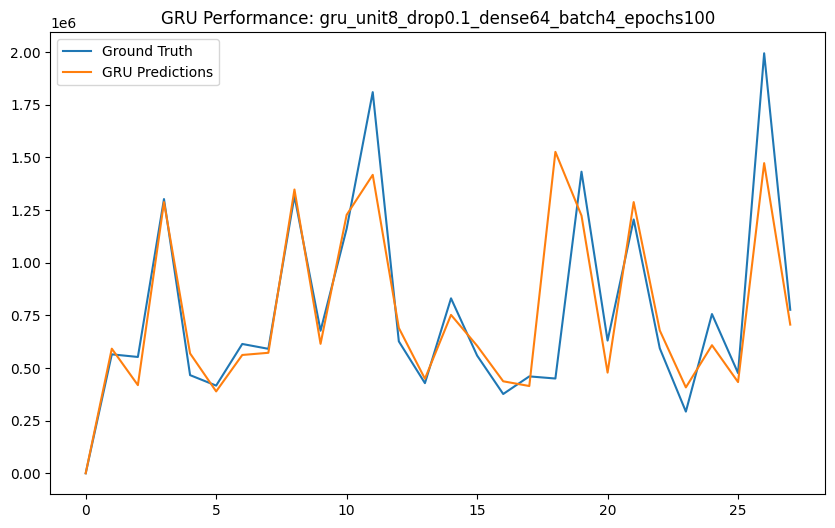

In [ ]:
config_key = 'gru_unit8_drop0.1_dense64_batch4_epochs100'
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(all_ground_truths[config_key], label='Ground Truth')
plt.plot(all_adjusted_predictions[config_key], label='GRU Predictions')
plt.title(f'GRU Performance: {config_key}')
plt.legend()
plt.show()

##LSTM

In [ ]:
# # Giảm số lượng/GRU unit, dense unit, epochs và sử dụng batch size nhỏ hơn để huấn luyện nhanh hơn.
# model_types = ['multi-scale']
# lstm_unit = [128, 256, 512]
# gru_unit = [8, 16, 32]
# drop_rate = [0.1, 0.2]
# dense_unit = [16, 32, 64]
# batch_size_num = [2, 4]
# epochs = [100]

model_types = ['lstm']
lstm_unit = [256,512]
gru_unit = [8,16]
drop_rate = [0.1,0.2]
dense_unit = [32,64]
batch_size_num = [4]
epochs = [100]

# # Replace the current parameter definitions
# model_types = ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble', 'lstm', 'gru']
# lstm_unit = [128]
# gru_unit = [8]
# drop_rate = [0.1]
# dense_unit = [64]
# batch_size_num = [2]
# epochs = [100]

import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class AttentionGRU(nn.Module):
    def __init__(self, input_dim, time_steps, gru_units, dropout_rate, dense_units):
        super(AttentionGRU, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # GRU layer
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(gru_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)
        batch_size = x.size(0)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # GRU layer - output: (batch, seq, hidden_size)
        gru_out, _ = self.gru(attention_mul)

        # Flatten and Dense layers
        flattened = self.flatten(gru_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, dropout_rate, dense_units):
        super(AttentionLSTM, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(lstm_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)
        batch_size = x.size(0)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # LSTM layer - output: (batch, seq, hidden_size)
        lstm_out, _ = self.lstm(attention_mul)

        # Flatten and Dense layers
        flattened = self.flatten(lstm_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class HybridLSTM_GRU(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(HybridLSTM_GRU, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM and GRU layers
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        # Combined size from both LSTM and GRU
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # LSTM and GRU layers
        lstm_out, _ = self.lstm(attention_mul)
        gru_out, _ = self.gru(attention_mul)

        # Concatenate LSTM and GRU outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Flatten and Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class SequentialHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(SequentialHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM followed by GRU
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.gru = nn.GRU(lstm_units, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(gru_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Sequential processing: LSTM then GRU
        lstm_out, _ = self.lstm(attention_mul)
        gru_out, _ = self.gru(lstm_out)

        # Dense layers
        flattened = self.flatten(gru_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class StackedHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(StackedHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Two stacked LSTM layers
        self.lstm1 = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units//2, batch_first=True)

        # Two stacked GRU layers
        self.gru1 = nn.GRU(input_dim, gru_units, batch_first=True)
        self.gru2 = nn.GRU(gru_units, gru_units//2, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units//2 + gru_units//2) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Stacked LSTM path
        lstm_out1, _ = self.lstm1(attention_mul)
        lstm_out2, _ = self.lstm2(lstm_out1)

        # Stacked GRU path
        gru_out1, _ = self.gru1(attention_mul)
        gru_out2, _ = self.gru2(gru_out1)

        # Concatenate final outputs
        combined = torch.cat((lstm_out2, gru_out2), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class BidirectionalHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(BidirectionalHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Bidirectional LSTM and GRU
        self.bilstm = nn.LSTM(input_dim, lstm_units, batch_first=True, bidirectional=True)
        self.bigru = nn.GRU(input_dim, gru_units, batch_first=True, bidirectional=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units*2 + gru_units*2) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Bidirectional networks
        lstm_out, _ = self.bilstm(attention_mul)
        gru_out, _ = self.bigru(attention_mul)

        # Concatenate outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class CNNRNNHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(CNNRNNHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # 1D CNN for feature extraction
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()

        # RNN layers
        self.lstm = nn.LSTM(64, lstm_units, batch_first=True)
        self.gru = nn.GRU(64, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * (time_steps-1), dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # CNN feature extraction
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        cnn_out = self.relu(self.conv1(x))
        cnn_out = self.maxpool(cnn_out)
        cnn_out = self.relu(self.conv2(cnn_out))
        cnn_out = cnn_out.permute(0, 2, 1)  # (batch, seq_len, features)

        # RNN processing
        lstm_out, _ = self.lstm(cnn_out)
        gru_out, _ = self.gru(cnn_out)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class MultiScaleHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(MultiScaleHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # LSTM for long-term dependencies
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)

        # GRU for shorter-term dependencies (operating on windows)
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Attention mechanism
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        # Full sequence for LSTM (long-term)
        lstm_out, _ = self.lstm(x)

        # Attention mechanism for GRU input
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights for GRU (short-term focus)
        gru_input = torch.mul(x, a)
        gru_out, _ = self.gru(gru_input)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class TransformerRNNHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units, nhead=4):
        super(TransformerRNNHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Input projection for transformer
        self.input_proj = nn.Linear(input_dim, 64)

        # Transformer encoder layer
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=nhead, dropout=dropout_rate, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

        # RNN layers
        self.lstm = nn.LSTM(64, lstm_units, batch_first=True)
        self.gru = nn.GRU(64, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Project input to transformer dimension
        x_proj = self.input_proj(x)

        # Apply transformer encoder
        transformer_out = self.transformer_encoder(x_proj)

        # Process with RNNs
        lstm_out, _ = self.lstm(transformer_out)
        gru_out, _ = self.gru(transformer_out)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class EnsembleHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(EnsembleHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Individual models
        self.lstm_model = AttentionLSTM(input_dim, time_steps, lstm_units, dropout_rate, dense_units)
        self.gru_model = AttentionGRU(input_dim, time_steps, gru_units, dropout_rate, dense_units)

        # Combination layer
        self.combine = nn.Linear(2, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Get predictions from each model
        lstm_pred = self.lstm_model(x)
        gru_pred = self.gru_model(x)

        # Combine predictions (learnable weights)
        combined = torch.cat((lstm_pred, gru_pred), dim=1)
        output = self.final_activation(self.combine(combined))

        return output



def build_model(train_X, train_Y, val_X, val_Y, model_type='gru', lstm_units=128, gru_units=128, drop_rate=0.3, dense_unit=64, batch_size=32, epochs=100):
    # Print training parameters
    train_X_tensor = torch.FloatTensor(train_X)
    train_Y_tensor = torch.FloatTensor(train_Y.reshape(-1, 1))
    val_X_tensor = torch.FloatTensor(val_X)
    val_Y_tensor = torch.FloatTensor(val_Y.reshape(-1, 1))

    # Create datasets and dataloaders
    train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
    val_dataset = TensorDataset(val_X_tensor, val_Y_tensor)

    # Create reproducible DataLoaders with fixed seeds
    train_generator = torch.Generator()
    train_generator.manual_seed(SEED)
    val_generator = torch.Generator()
    val_generator.manual_seed(SEED)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=train_generator)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, generator=val_generator)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    time_steps = train_X.shape[1]
    input_dim = train_X.shape[2]

    # Initialize model with fixed initial weights
    torch.manual_seed(SEED)

    if model_type == 'gru':
        model = AttentionGRU(input_dim, time_steps, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'lstm':
        model = AttentionLSTM(input_dim, time_steps, lstm_units, drop_rate, dense_unit).to(device)
    elif model_type == 'hybrid':
        model = HybridLSTM_GRU(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'sequential':
        model = SequentialHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'stacked':
        model = StackedHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'bidirectional':
        model = BidirectionalHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'cnn-rnn':
        model = CNNRNNHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'multi-scale':
        model = MultiScaleHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'transformer-rnn':
        model = TransformerRNNHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'ensemble':
        model = EnsembleHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters())
    criterion = nn.L1Loss()  # MAE loss

    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5
    lr_factor = 0.01

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Print progress
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

        # Learning rate schedule based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= lr_factor
                patience_counter = 0
                print(f'Reducing learning rate by factor of {lr_factor}')

    return model

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mape

def walk_forward(train_X, train_Y, val_X, val_Y, test_X, test_Y, grid_search, scaler):
    r, f, c = test_X.shape
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    all_predictions = {}
    all_adjusted_predictions = {}
    all_ground_truths = {}

    # Create lists to store all evaluation results
    original_valuelists = []
    adjusted_valuelists = []

    for x in grid_search:
        history_x = np.array([x for x in train_X])
        history_y = np.array([y for y in train_Y])
        predictions = list()
        adjusted_predictions = list()
        groundtrue = list()

        # Extract model type first to determine how to unpack the rest
        model_type = x[0]

        # Create the appropriate config_key and extract parameters based on model type
        if model_type in ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble']:
            # Hybrid model has 7 parameters
            model_type, lstm_unit_val, gru_unit_val, drop, dense, batch, epoch = x
            units = f"L{lstm_unit_val}_G{gru_unit_val}"  # For logging
            config_key = f"{model_type}_lstmUnit{lstm_unit_val}_gruUnit{gru_unit_val}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"
        else:
            # LSTM and GRU models have 6 parameters
            model_type, units, drop, dense, batch, epoch = x
            config_key = f"{model_type}_unit{units}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"

        print("\n" + "*"*50)
        print(f"Starting walk-forward validation with parameters:")
        print(f"Model Type: {model_type}, Units: {units}, Dropout: {drop}, Dense Units: {dense}")
        print(f"Batch Size: {batch}, Epochs: {epoch}")
        print(f"Device: {device}")
        print(f"Total test samples: {len(test_X)}")
        print("*"*50 + "\n")

        for i in range(len(test_X)):
            print(f"\nTest iteration {i+1}/{len(test_X)}")
            print(f"Current training set size: {history_x.shape[0]} samples")

            if model_type in ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble']:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                lstm_units=lstm_unit_val, gru_units=gru_unit_val, drop_rate=drop,
                                dense_unit=dense, batch_size=batch, epochs=epoch)
            else:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                lstm_units=units if model_type == 'lstm' else 128,
                                gru_units=units if model_type == 'gru' else 128,
                                drop_rate=drop, dense_unit=dense, batch_size=batch, epochs=epoch)

            # Rest of the function remains the same
            model.eval()

            # Convert test data to tensor
            test_tensor = torch.FloatTensor(test_X[i].reshape(1, f, c)).to(device)

            # Predict
            with torch.no_grad():
                yhat = model(test_tensor).cpu().numpy()

            inv_yhat, inv_y = inverscale(yhat, test_X[i], test_Y[i], scaler)
            prev_month_lockdown = test_X[i][11][5]
            adjusted_inv_yhat = inv_yhat * (1 - prev_month_lockdown)
            predictions.append(inv_yhat)
            adjusted_predictions.append(adjusted_inv_yhat)
            groundtrue.append(inv_y)

            # Observation
            obs_x = test_X[i]
            obs_y = test_Y[i]

            history_x = np.append(history_x, [obs_x], axis=0)
            history_y = np.append(history_y, obs_y)

        # Store predictions and ground truth for this configuration
        all_predictions[config_key] = np.array(predictions).flatten()
        all_adjusted_predictions[config_key] = np.array(adjusted_predictions).flatten()
        all_ground_truths[config_key] = np.array(groundtrue).flatten()

        original_valuelist = evalue(predictions, groundtrue)
        original_valuelist['model_type'] = model_type
        original_valuelist['units'] = units
        original_valuelist['drop_rate'] = drop
        original_valuelist['dense_unit'] = dense
        original_valuelist['batch_size'] = batch
        original_valuelist['epochs'] = epoch

        # Evaluate with adjusted predictions
        adjusted_valuelist = evalue(adjusted_predictions, groundtrue)
        adjusted_valuelist['model_type'] = model_type
        adjusted_valuelist['units'] = units
        adjusted_valuelist['drop_rate'] = drop
        adjusted_valuelist['dense_unit'] = dense
        adjusted_valuelist['batch_size'] = batch
        adjusted_valuelist['epochs'] = epoch

        # Append to the lists of results
        original_valuelists.append(original_valuelist)
        adjusted_valuelists.append(adjusted_valuelist)

    # Combine all results
    all_original_valuelist = pd.concat(original_valuelists, ignore_index=True)
    all_adjusted_valuelist = pd.concat(adjusted_valuelists, ignore_index=True)

    return all_original_valuelist, all_adjusted_valuelist, all_predictions, all_ground_truths, all_adjusted_predictions

def evalue(yhat, inv_y):
    valuelist = {}
    DLM_rmse = sqrt(mean_squared_error(inv_y, yhat))
    valuelist.update({'RMSE': {'DLM': DLM_rmse}})
    DLM_mae = mean_absolute_error(inv_y, yhat)
    valuelist.update({'MAE': {'DLM': DLM_mae}})
    DLM_mape = mean_absolute_percentage_error(inv_y, yhat)
    valuelist.update({'MAPE': {'DLM': DLM_mape}})
    return pd.DataFrame(valuelist)

def inverscale(yhat, test_X, test_Y, scaler):
    feature = len(scaler.scale_)
    test_Y = np.array(test_Y)
    test_X = test_X[1, 0:feature]
    test_X = test_X.reshape(1, test_X.shape[0])

    if len(yhat.shape) == 1:
        yhat = yhat.reshape(len(yhat), 1)

    inv_yhat = concatenate((yhat, test_X[:, :-1]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    test_Y = test_Y.reshape(1, 1)
    inv_y = concatenate((test_Y, test_X[:, :-1]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
    return inv_yhat, inv_y

if __name__ == '__main__':
    values = reframed.values
    reframed_with_dates_values = reframed_with_dates.values

    # Import train_test_split for random splitting
    from sklearn.model_selection import train_test_split

    # Drop the date column for the splitting but keep track of indices
    reframed_without_dates = reframed.copy()

    # First split: 80% train+val, 20% test
    train_val_indices, test_indices = train_test_split(
        np.arange(len(reframed_without_dates)),
        test_size=0.2,
        random_state=SEED
    )

    # Second split: From the 80%, use 7/8 for train (70% of total) and 1/8 for val (10% of total)
    train_indices, val_indices = train_test_split(
        train_val_indices,
        test_size=0.125,  # 0.125 * 0.8 = 0.1 (10% of total)
        random_state=SEED
    )

    # Extract values for train, validation, and test sets
    train_data = reframed.iloc[train_indices].values
    val_data = reframed.iloc[val_indices].values
    test_data = reframed.iloc[test_indices].values

    # Store the corresponding dates for reference
    train_dates = reframed_with_dates.iloc[train_indices]['date']
    val_dates = reframed_with_dates.iloc[val_indices]['date']
    test_dates = reframed_with_dates.iloc[test_indices]['date']

    # Split into X and Y
    train_X, train_Y = train_data[:, :-1], train_data[:, -1]
    val_X, val_Y = val_data[:, :-1], val_data[:, -1]
    test_X, test_Y = test_data[:, :-1], test_data[:, -1]

    # Reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape(train_X.shape[0], 12, int(train_X.shape[1]/12))
    val_X = val_X.reshape(val_X.shape[0], 12, int(val_X.shape[1]/12))
    test_X = test_X.reshape(test_X.shape[0], 12, int(test_X.shape[1]/12))

    # Modified grid search creation for all model types
    grid_search = []
    for model_type in model_types:
        if model_type == 'lstm':
            grid_search.extend(
                list(itertools.product([model_type], lstm_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )
        elif model_type == 'gru':
            grid_search.extend(
                list(itertools.product([model_type], gru_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )
        else:
            # All other models (hybrid, sequential, stacked, etc.) need both LSTM and GRU units
            grid_search.extend(
                list(itertools.product([model_type], lstm_unit, gru_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )

    original_valuelist, adjusted_valuelist, all_predictions, all_ground_truths, all_adjusted_predictions = walk_forward(train_X, train_Y, val_X, val_Y, test_X, test_Y, grid_search, scaler)

    # Group results by model type
    # gru_results = adjusted_valuelist[adjusted_valuelist['model_type'] == 'gru']
    # lstm_results = adjusted_valuelist[adjusted_valuelist['model_type'] == 'lstm']

    print("Results:")
    print(adjusted_valuelist)

Streaming output truncated to the last 5000 lines.
Epoch 73/100, Train Loss: 0.0364, Val Loss: 0.0440
Reducing learning rate by factor of 0.01
Epoch 74/100, Train Loss: 0.0363, Val Loss: 0.0440
Epoch 75/100, Train Loss: 0.0367, Val Loss: 0.0440
Epoch 76/100, Train Loss: 0.0370, Val Loss: 0.0440
Epoch 77/100, Train Loss: 0.0365, Val Loss: 0.0440
Epoch 78/100, Train Loss: 0.0362, Val Loss: 0.0440
Reducing learning rate by factor of 0.01
Epoch 79/100, Train Loss: 0.0361, Val Loss: 0.0440
Epoch 80/100, Train Loss: 0.0357, Val Loss: 0.0440
Epoch 81/100, Train Loss: 0.0371, Val Loss: 0.0440
Epoch 82/100, Train Loss: 0.0379, Val Loss: 0.0440
Epoch 83/100, Train Loss: 0.0361, Val Loss: 0.0440
Reducing learning rate by factor of 0.01
Epoch 84/100, Train Loss: 0.0370, Val Loss: 0.0440
Epoch 85/100, Train Loss: 0.0363, Val Loss: 0.0440
Epoch 86/100, Train Loss: 0.0364, Val Loss: 0.0440
Epoch 87/100, Train Loss: 0.0370, Val Loss: 0.0440
Epoch 88/100, Train Loss: 0.0365, Val Loss: 0.0440
Reducing l

In [ ]:
adjusted_valuelist.to_csv( '/content/drive/MyDrive/LSTM_random.csv', index=False)
pd.DataFrame(all_adjusted_predictions).to_csv("/content/drive/MyDrive/all_adjusted_predictions_LSTM_random.csv", index=False)
pd.DataFrame(all_ground_truths).to_csv("/content/drive/MyDrive/all_ground_truths_LSTM_random.csv", index=False)

In [ ]:
adjusted_valuelist

,RMSE,MAE,MAPE,model_type,units,drop_rate,dense_unit,batch_size,epochs
0,240585.072923,108315.003348,9.835603,lstm,256,0.1,32,4,100
1,252468.690125,111569.946429,10.189485,lstm,256,0.1,64,4,100
2,241551.867275,119975.191964,4.917729,lstm,256,0.2,32,4,100
3,212744.688882,99794.498884,9.813545,lstm,256,0.2,64,4,100
4,237389.188356,103371.850446,4.304721,lstm,512,0.1,32,4,100
5,233327.415288,99766.943080,8.443049,lstm,512,0.1,64,4,100
6,241813.786737,112261.626116,7.455519,lstm,512,0.2,32,4,100
7,223458.881703,99858.380580,5.419324,lstm,512,0.2,64,4,100


In [ ]:
all_adjusted_predictions

{'lstm_unit256_drop0.1_dense32_batch4_epochs100': array([      0.  ,  620281.2 ,  476042.4 , 1385132.1 ,  566537.3 ,
         415190.6 ,  589163.9 ,  610282.06, 1265234.1 ,  608050.56,
        1162219.  , 1493865.5 ,  684290.5 ,  416994.16,  810215.75,
         599502.44,  415822.12,  450570.62, 1580895.9 , 1317135.  ,
         513524.3 , 1295883.1 ,  568279.06,  382833.97,  669407.75,
         459276.47, 1608031.1 ,  776279.8 ], dtype=float32),
 'lstm_unit256_drop0.1_dense64_batch4_epochs100': array([      0.  ,  622279.7 ,  436755.4 , 1281191.2 ,  522234.6 ,
         406610.1 ,  608010.3 ,  688814.7 , 1417494.6 ,  615734.56,
        1199657.4 , 1626889.4 ,  607761.7 ,  417674.94,  805860.8 ,
         604994.3 ,  400079.66,  460013.47, 1606530.6 , 1240840.8 ,
         549384.5 , 1254397.4 ,  603040.8 ,  381222.66,  647270.06,
         471475.94, 1447417.  ,  794483.44], dtype=float32),
 'lstm_unit256_drop0.2_dense32_batch4_epochs100': array([      0.  ,  592508.2 ,  470278.72, 1379261

In [ ]:
all_ground_truths

{'lstm_unit256_drop0.1_dense32_batch4_epochs100': array([      0. ,  564736. ,  552234. , 1301909. ,  466000. ,  416249. ,
         613919. ,  590881. , 1315792. ,  676719. , 1161114. , 1809580. ,
         626324. ,  427935. ,  830608. ,  559002. ,  376400. ,  460000. ,
         449923. , 1431845. ,  630000. , 1205157. ,  593566. ,  292843. ,
         756000. ,  475733. , 1994124.9,  776174. ], dtype=float32),
 'lstm_unit256_drop0.1_dense64_batch4_epochs100': array([      0. ,  564736. ,  552234. , 1301909. ,  466000. ,  416249. ,
         613919. ,  590881. , 1315792. ,  676719. , 1161114. , 1809580. ,
         626324. ,  427935. ,  830608. ,  559002. ,  376400. ,  460000. ,
         449923. , 1431845. ,  630000. , 1205157. ,  593566. ,  292843. ,
         756000. ,  475733. , 1994124.9,  776174. ], dtype=float32),
 'lstm_unit256_drop0.2_dense32_batch4_epochs100': array([      0. ,  564736. ,  552234. , 1301909. ,  466000. ,  416249. ,
         613919. ,  590881. , 1315792. ,  676719.

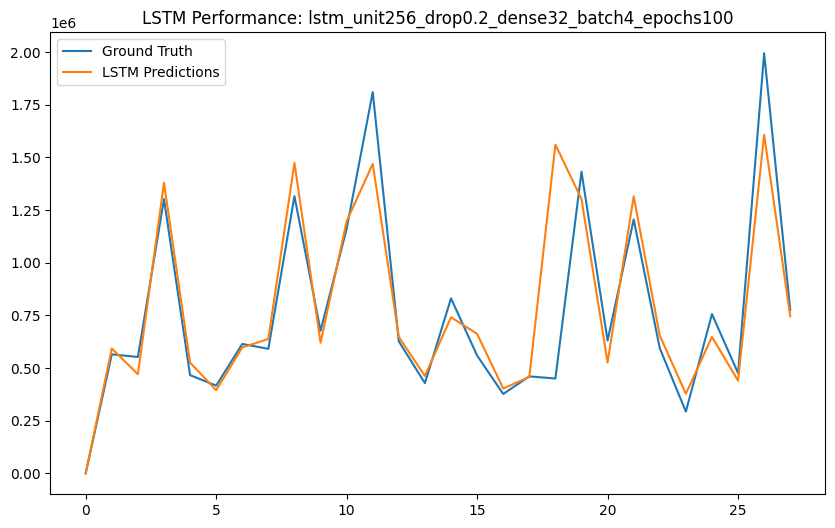

In [ ]:
config_key = 'lstm_unit256_drop0.2_dense32_batch4_epochs100'
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(all_ground_truths[config_key], label='Ground Truth')
plt.plot(all_adjusted_predictions[config_key], label='LSTM Predictions')
plt.title(f'LSTM Performance: {config_key}')
plt.legend()
plt.show()

#Compare to Other Models

##FIXED

In [3]:
# # Giảm số lượng/GRU unit, dense unit, epochs và sử dụng batch size nhỏ hơn để huấn luyện nhanh hơn.
# model_types = ['multi-scale']
# lstm_unit = [128, 256, 512]
# gru_unit = [8, 16, 32]
# drop_rate = [0.1, 0.2]
# dense_unit = [16, 32, 64]
# batch_size_num = [2, 4]
# epochs = [100]

model_types = ['cnn', 'rf', 'xgb', 'gbm']
lstm_unit = [256,512]
gru_unit = [8,16]
drop_rate = [0.1,0.2]
dense_unit = [32,64]
batch_size_num = [4]
epochs = [100]
n_estimators = [100, 200]

# # Replace the current parameter definitions
# model_types = ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble', 'lstm', 'gru']
# lstm_unit = [128]
# gru_unit = [8]
# drop_rate = [0.1]
# dense_unit = [64]
# batch_size_num = [2]
# epochs = [100]

import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.base import BaseEstimator

class CNNModel(nn.Module):
    def __init__(self, input_dim, time_steps, dropout_rate=0.2, dense_units=64):
        super(CNNModel, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # CNN layers
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        # Calculate the size after conv + pooling layers
        cnn_output_size = 64 * (time_steps // 2)

        # Fully connected layers
        self.fc1 = nn.Linear(cnn_output_size, dense_units)
        self.fc2 = nn.Linear(dense_units, dense_units // 2)
        self.fc3 = nn.Linear(dense_units // 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: (batch, time_steps, features)
        # Reshape for CNN: (batch, features, time_steps)
        x = x.permute(0, 2, 1)

        # Apply CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = self.relu(self.conv2(x))
        x = self.dropout(x)

        x = self.relu(self.conv3(x))
        x = self.flatten(x)

        # Apply fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))

        return x

class AttentionGRU(nn.Module):
    def __init__(self, input_dim, time_steps, gru_units, dropout_rate, dense_units):
        super(AttentionGRU, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # GRU layer
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(gru_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)
        batch_size = x.size(0)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # GRU layer - output: (batch, seq, hidden_size)
        gru_out, _ = self.gru(attention_mul)

        # Flatten and Dense layers
        flattened = self.flatten(gru_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, dropout_rate, dense_units):
        super(AttentionLSTM, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(lstm_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)
        batch_size = x.size(0)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # LSTM layer - output: (batch, seq, hidden_size)
        lstm_out, _ = self.lstm(attention_mul)

        # Flatten and Dense layers
        flattened = self.flatten(lstm_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class HybridLSTM_GRU(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(HybridLSTM_GRU, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM and GRU layers
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        # Combined size from both LSTM and GRU
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # LSTM and GRU layers
        lstm_out, _ = self.lstm(attention_mul)
        gru_out, _ = self.gru(attention_mul)

        # Concatenate LSTM and GRU outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Flatten and Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class SequentialHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(SequentialHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM followed by GRU
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.gru = nn.GRU(lstm_units, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(gru_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Sequential processing: LSTM then GRU
        lstm_out, _ = self.lstm(attention_mul)
        gru_out, _ = self.gru(lstm_out)

        # Dense layers
        flattened = self.flatten(gru_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class StackedHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(StackedHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Two stacked LSTM layers
        self.lstm1 = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units//2, batch_first=True)

        # Two stacked GRU layers
        self.gru1 = nn.GRU(input_dim, gru_units, batch_first=True)
        self.gru2 = nn.GRU(gru_units, gru_units//2, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units//2 + gru_units//2) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Stacked LSTM path
        lstm_out1, _ = self.lstm1(attention_mul)
        lstm_out2, _ = self.lstm2(lstm_out1)

        # Stacked GRU path
        gru_out1, _ = self.gru1(attention_mul)
        gru_out2, _ = self.gru2(gru_out1)

        # Concatenate final outputs
        combined = torch.cat((lstm_out2, gru_out2), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class BidirectionalHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(BidirectionalHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Bidirectional LSTM and GRU
        self.bilstm = nn.LSTM(input_dim, lstm_units, batch_first=True, bidirectional=True)
        self.bigru = nn.GRU(input_dim, gru_units, batch_first=True, bidirectional=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units*2 + gru_units*2) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Bidirectional networks
        lstm_out, _ = self.bilstm(attention_mul)
        gru_out, _ = self.bigru(attention_mul)

        # Concatenate outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class CNNRNNHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(CNNRNNHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # 1D CNN for feature extraction
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()

        # RNN layers
        self.lstm = nn.LSTM(64, lstm_units, batch_first=True)
        self.gru = nn.GRU(64, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * (time_steps-1), dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # CNN feature extraction
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        cnn_out = self.relu(self.conv1(x))
        cnn_out = self.maxpool(cnn_out)
        cnn_out = self.relu(self.conv2(cnn_out))
        cnn_out = cnn_out.permute(0, 2, 1)  # (batch, seq_len, features)

        # RNN processing
        lstm_out, _ = self.lstm(cnn_out)
        gru_out, _ = self.gru(cnn_out)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class MultiScaleHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(MultiScaleHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # LSTM for long-term dependencies
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)

        # GRU for shorter-term dependencies (operating on windows)
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Attention mechanism
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        # Full sequence for LSTM (long-term)
        lstm_out, _ = self.lstm(x)

        # Attention mechanism for GRU input
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights for GRU (short-term focus)
        gru_input = torch.mul(x, a)
        gru_out, _ = self.gru(gru_input)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class TransformerRNNHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units, nhead=4):
        super(TransformerRNNHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Input projection for transformer
        self.input_proj = nn.Linear(input_dim, 64)

        # Transformer encoder layer
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=nhead, dropout=dropout_rate, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

        # RNN layers
        self.lstm = nn.LSTM(64, lstm_units, batch_first=True)
        self.gru = nn.GRU(64, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Project input to transformer dimension
        x_proj = self.input_proj(x)

        # Apply transformer encoder
        transformer_out = self.transformer_encoder(x_proj)

        # Process with RNNs
        lstm_out, _ = self.lstm(transformer_out)
        gru_out, _ = self.gru(transformer_out)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class EnsembleHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(EnsembleHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Individual models
        self.lstm_model = AttentionLSTM(input_dim, time_steps, lstm_units, dropout_rate, dense_units)
        self.gru_model = AttentionGRU(input_dim, time_steps, gru_units, dropout_rate, dense_units)

        # Combination layer
        self.combine = nn.Linear(2, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Get predictions from each model
        lstm_pred = self.lstm_model(x)
        gru_pred = self.gru_model(x)

        # Combine predictions (learnable weights)
        combined = torch.cat((lstm_pred, gru_pred), dim=1)
        output = self.final_activation(self.combine(combined))

        return output

class StackingEnsemble(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(StackingEnsemble, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # First-level models (weak learners)
        self.lstm_model = AttentionLSTM(input_dim, time_steps, lstm_units, dropout_rate, dense_units)
        self.gru_model = AttentionGRU(input_dim, time_steps, gru_units, dropout_rate, dense_units)

        # Enhanced meta-learner with more context awareness
        # Takes base model predictions plus context features from the original input
        self.context_extractor = nn.Sequential(
            nn.Linear(input_dim * time_steps, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Meta-learner network with enhanced capacity and context awareness
        self.meta_learner = nn.Sequential(
            nn.Linear(2 + 32, 64),  # 2 base predictions + 32 context features
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        # Attention mechanism for base model outputs
        self.attention = nn.Sequential(
            nn.Linear(2, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Get predictions from base models
        lstm_pred = self.lstm_model(x)
        gru_pred = self.gru_model(x)

        # Extract context features from input
        flattened_input = x.reshape(batch_size, -1)
        context_features = self.context_extractor(flattened_input)

        # Combine base model predictions
        base_preds = torch.cat((lstm_pred, gru_pred), dim=1)

        # Calculate attention weights for base predictions
        attention_weights = self.attention(base_preds)

        # Apply attention to base predictions
        weighted_preds = base_preds * attention_weights

        # Combine everything for the meta-learner
        meta_features = torch.cat((weighted_preds, context_features), dim=1)

        # Final prediction
        final_pred = self.meta_learner(meta_features)

        return final_pred

    def train_weak_learners(self, train_loader, val_loader, epochs=10, device='cpu'):
        """
        Pre-train the weak learners separately before training the full ensemble
        """
        print("Pre-training weak learners...")
        criterion = nn.L1Loss()

        # Train LSTM model
        print("Pre-training LSTM model...")
        optimizer_lstm = optim.Adam(self.lstm_model.parameters(), lr=0.001)
        best_lstm_loss = float('inf')
        lstm_patience = 0

        for epoch in range(epochs):
            # Training
            self.lstm_model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer_lstm.zero_grad()
                outputs = self.lstm_model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer_lstm.step()
                train_loss += loss.item()

            # Validation
            self.lstm_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = self.lstm_model(inputs)
                    val_loss += criterion(outputs, targets).item()

            print(f"LSTM Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

            # Early stopping check
            if val_loss < best_lstm_loss:
                best_lstm_loss = val_loss
                lstm_patience = 0
            else:
                lstm_patience += 1
                if lstm_patience >= 3:
                    print("Early stopping LSTM training")
                    break

        # Train GRU model
        print("Pre-training GRU model...")
        optimizer_gru = optim.Adam(self.gru_model.parameters(), lr=0.001)
        best_gru_loss = float('inf')
        gru_patience = 0

        for epoch in range(epochs):
            # Training
            self.gru_model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer_gru.zero_grad()
                outputs = self.gru_model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer_gru.step()
                train_loss += loss.item()

            # Validation
            self.gru_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = self.gru_model(inputs)
                    val_loss += criterion(outputs, targets).item()

            print(f"GRU Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

            # Early stopping check
            if val_loss < best_gru_loss:
                best_gru_loss = val_loss
                gru_patience = 0
            else:
                gru_patience += 1
                if gru_patience >= 3:
                    print("Early stopping GRU training")
                    break

        # Generate predictions from trained base models for meta-learner warm-up
        print("Preparing meta-learner with base model predictions...")
        self.lstm_model.eval()
        self.gru_model.eval()

        # Freeze the weights of weak learners
        for param in self.lstm_model.parameters():
            param.requires_grad = False

        for param in self.gru_model.parameters():
            param.requires_grad = False

        print("Weak learners trained and frozen.")

class CNNModel(nn.Module):
    def __init__(self, input_dim, time_steps, dropout_rate=0.2, dense_units=64):
        super(CNNModel, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # CNN layers
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        # Calculate the size after conv + pooling layers
        cnn_output_size = 64 * (time_steps // 2)

        # Fully connected layers
        self.fc1 = nn.Linear(cnn_output_size, dense_units)
        self.fc2 = nn.Linear(dense_units, dense_units // 2)
        self.fc3 = nn.Linear(dense_units // 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: (batch, time_steps, features)
        # Reshape for CNN: (batch, features, time_steps)
        x = x.permute(0, 2, 1)

        # Apply CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = self.relu(self.conv2(x))
        x = self.dropout(x)

        x = self.relu(self.conv3(x))
        x = self.flatten(x)

        # Apply fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))

        return x

class SklearnModelWrapper:
    """Wrapper for traditional ML models to maintain interface consistency with PyTorch models"""
    def __init__(self, model_type='rf', **kwargs):
        self.model_type = model_type

        if model_type == 'rf':
            self.model = RandomForestRegressor(**kwargs)
        elif model_type == 'gbm':
            self.model = GradientBoostingRegressor(**kwargs)
        elif model_type == 'xgb':
            self.model = xgb.XGBRegressor(**kwargs)
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        self.device = 'cpu'  # Traditional ML models run on CPU

    def to(self, device):
        # Dummy method for compatibility with PyTorch interface
        self.device = device
        return self

    def train(self):
        # Dummy method for compatibility with PyTorch interface
        pass

    def eval(self):
        # Dummy method for compatibility with PyTorch interface
        pass

    def __call__(self, x):
        # For inference - handle both PyTorch tensors and numpy arrays
        if isinstance(x, torch.Tensor):
            x_np = x.detach().cpu().numpy()
        else:
            x_np = x

        # Reshape input for traditional ML models: from (batch, time_steps, features) to (batch, time_steps*features)
        batch_size = x_np.shape[0]
        x_flat = x_np.reshape(batch_size, -1)

        # Get predictions
        preds = self.model.predict(x_flat)

        # Convert back to appropriate format
        if isinstance(x, torch.Tensor):
            return torch.FloatTensor(preds.reshape(-1, 1))
        return preds.reshape(-1, 1)

    def fit(self, X, y):
        """Train the model using scikit-learn's fit method"""
        # Reshape input if necessary
        if len(X.shape) == 3:  # (batch, time_steps, features)
            X_flat = X.reshape(X.shape[0], -1)
        else:
            X_flat = X

        return self.model.fit(X_flat, y)

def build_model(train_X, train_Y, val_X, val_Y, model_type='gru', lstm_units=128, gru_units=128,
               drop_rate=0.3, dense_unit=64, batch_size=32, epochs=100, n_estimators=100):
    # Print training parameters
    train_X_tensor = torch.FloatTensor(train_X)
    train_Y_tensor = torch.FloatTensor(train_Y.reshape(-1, 1))
    val_X_tensor = torch.FloatTensor(val_X)
    val_Y_tensor = torch.FloatTensor(val_Y.reshape(-1, 1))

    # Create datasets and dataloaders
    train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
    val_dataset = TensorDataset(val_X_tensor, val_Y_tensor)

    # Create reproducible DataLoaders with fixed seeds
    train_generator = torch.Generator()
    train_generator.manual_seed(SEED)
    val_generator = torch.Generator()
    val_generator.manual_seed(SEED)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=train_generator)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, generator=val_generator)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    time_steps = train_X.shape[1]
    input_dim = train_X.shape[2]

    # Initialize model with fixed initial weights
    torch.manual_seed(SEED)

    # Determine model type and create appropriate model
    if model_type == 'gru':
        model = AttentionGRU(input_dim, time_steps, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'lstm':
        model = AttentionLSTM(input_dim, time_steps, lstm_units, drop_rate, dense_unit).to(device)
    elif model_type == 'hybrid':
        model = HybridLSTM_GRU(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'sequential':
        model = SequentialHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'stacked':
        model = StackedHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'bidirectional':
        model = BidirectionalHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'cnn-rnn':
        model = CNNRNNHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'multi-scale':
        model = MultiScaleHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'transformer-rnn':
        model = TransformerRNNHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'ensemble':
        model = EnsembleHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'stacking':
        model = StackingEnsemble(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
        # Pre-train weak learners
        model.train_weak_learners(train_loader, val_loader, epochs=10, device=device)
    elif model_type == 'cnn':
        model = CNNModel(input_dim, time_steps, drop_rate, dense_unit).to(device)
    elif model_type in ['rf', 'xgb', 'gbm']:
        # Initialize appropriate traditional ML model
        if model_type == 'rf':
            model = SklearnModelWrapper(model_type='rf', n_estimators=n_estimators, random_state=SEED)
        elif model_type == 'xgb':
            model = SklearnModelWrapper(model_type='xgb', n_estimators=n_estimators, random_state=SEED,
                                       learning_rate=0.1, max_depth=6)
        elif model_type == 'gbm':
            model = SklearnModelWrapper(model_type='gbm', n_estimators=n_estimators, random_state=SEED,
                                       learning_rate=0.1, max_depth=6)

        # Directly train traditional ML models (no epochs needed)
        train_X_flat = train_X.reshape(train_X.shape[0], -1)
        model.fit(train_X_flat, train_Y)
        return model
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # For deep learning models, continue with the existing training loop
    if model_type not in ['rf', 'xgb', 'gbm']:
        # Initialize optimizer and loss function
        optimizer = optim.Adam(model.parameters())
        criterion = nn.L1Loss()  # MAE loss

        # Training loop
        best_val_loss = float('inf')
        patience_counter = 0
        patience = 5
        lr_factor = 0.01

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

            # Print progress
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

            # Learning rate schedule based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] *= lr_factor
                    patience_counter = 0
                    print(f'Reducing learning rate by factor of {lr_factor}')

    return model

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mape

def walk_forward(train_X, train_Y, val_X, val_Y, test_X, test_Y, grid_search, scaler):
    r, f, c = test_X.shape
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    all_predictions = {}
    all_adjusted_predictions = {}
    all_ground_truths = {}

    # Create lists to store all evaluation results
    original_valuelists = []
    adjusted_valuelists = []

    for x in grid_search:
        history_x = np.array([x for x in train_X])
        history_y = np.array([y for y in train_Y])
        predictions = list()
        adjusted_predictions = list()
        groundtrue = list()

        # Extract model type first to determine how to unpack the rest
        model_type = x[0]

        # Create the appropriate config_key and extract parameters based on model type
        if model_type in ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble', 'stacking']:
            # Hybrid model has 7 parameters
            model_type, lstm_unit_val, gru_unit_val, drop, dense, batch, epoch = x
            units = f"L{lstm_unit_val}_G{gru_unit_val}"  # For logging
            config_key = f"{model_type}_lstmUnit{lstm_unit_val}_gruUnit{gru_unit_val}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"
        elif model_type in ['rf', 'xgb', 'gbm']:
            # Tree-based models have only 2 parameters
            model_type, n_estimators = x
            units = f"Est{n_estimators}"  # For logging
            config_key = f"{model_type}_estimators{n_estimators}"
            drop = 0
            dense = 0
            batch = 0
            epoch = 0
        elif model_type == 'cnn':
            # CNN model has 6 parameters but no specific units parameter
            model_type, _, drop, dense, batch, epoch = x
            units = "CNN"  # For logging
            config_key = f"{model_type}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"
        else:
            # LSTM and GRU models have 6 parameters
            model_type, units, drop, dense, batch, epoch = x
            config_key = f"{model_type}_unit{units}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"

        print("\n" + "*"*50)
        print(f"Starting walk-forward validation with parameters:")
        print(f"Model Type: {model_type}, Units/Estimators: {units}")
        if model_type not in ['rf', 'xgb', 'gbm']:
            print(f"Dropout: {drop}, Dense Units: {dense}")
            print(f"Batch Size: {batch}, Epochs: {epoch}")
        else:
            print(f"n_estimators: {n_estimators}")
        print(f"Device: {device}")
        print(f"Total test samples: {len(test_X)}")
        print("*"*50 + "\n")

        for i in range(len(test_X)):
            print(f"\nTest iteration {i+1}/{len(test_X)}")
            print(f"Current training set size: {history_x.shape[0]} samples")

            # Build model based on model type
            if model_type in ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble', 'stacking']:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                lstm_units=lstm_unit_val, gru_units=gru_unit_val, drop_rate=drop,
                                dense_unit=dense, batch_size=batch, epochs=epoch)
            elif model_type in ['rf', 'xgb', 'gbm']:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                n_estimators=n_estimators)
            elif model_type == 'cnn':
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                drop_rate=drop, dense_unit=dense, batch_size=batch, epochs=epoch)
            else:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                lstm_units=units if model_type == 'lstm' else 128,
                                gru_units=units if model_type == 'gru' else 128,
                                drop_rate=drop, dense_unit=dense, batch_size=batch, epochs=epoch)

            # Set model to eval mode if it's a PyTorch model
            if hasattr(model, 'eval'):
                model.eval()

            # Convert test data to appropriate format
            if model_type in ['rf', 'xgb', 'gbm']:
                # For traditional ML models, flatten the input
                test_data = test_X[i].reshape(1, -1)
                yhat = model(test_data)
            else:
                # For deep learning models, use tensors
                test_tensor = torch.FloatTensor(test_X[i].reshape(1, f, c)).to(device)
                with torch.no_grad():
                    yhat = model(test_tensor).cpu().numpy()

            inv_yhat, inv_y = inverscale(yhat, test_X[i], test_Y[i], scaler)
            prev_month_lockdown = test_X[i][11][5]
            adjusted_inv_yhat = inv_yhat * (1 - prev_month_lockdown)
            predictions.append(inv_yhat)
            adjusted_predictions.append(adjusted_inv_yhat)
            groundtrue.append(inv_y)

            # Observation
            obs_x = test_X[i]
            obs_y = test_Y[i]

            history_x = np.append(history_x, [obs_x], axis=0)
            history_y = np.append(history_y, obs_y)

        # Store predictions and ground truth for this configuration
        all_predictions[config_key] = np.array(predictions).flatten()
        all_adjusted_predictions[config_key] = np.array(adjusted_predictions).flatten()
        all_ground_truths[config_key] = np.array(groundtrue).flatten()

        original_valuelist = evalue(predictions, groundtrue)
        original_valuelist['model_type'] = model_type
        if model_type in ['rf', 'xgb', 'gbm']:
            original_valuelist['n_estimators'] = n_estimators
            original_valuelist['units'] = "N/A"
            original_valuelist['drop_rate'] = "N/A"
            original_valuelist['dense_unit'] = "N/A"
            original_valuelist['batch_size'] = "N/A"
            original_valuelist['epochs'] = "N/A"
        elif model_type == 'cnn':
            original_valuelist['units'] = "N/A"
            original_valuelist['drop_rate'] = drop
            original_valuelist['dense_unit'] = dense
            original_valuelist['batch_size'] = batch
            original_valuelist['epochs'] = epoch
        else:
            original_valuelist['units'] = units
            original_valuelist['drop_rate'] = drop
            original_valuelist['dense_unit'] = dense
            original_valuelist['batch_size'] = batch
            original_valuelist['epochs'] = epoch

        # Evaluate with adjusted predictions
        adjusted_valuelist = evalue(np.array(adjusted_predictions).flatten(), np.array(groundtrue).flatten())
        adjusted_valuelist['model_type'] = model_type
        if model_type in ['rf', 'xgb', 'gbm']:
            adjusted_valuelist['n_estimators'] = n_estimators
            adjusted_valuelist['units'] = "N/A"
            adjusted_valuelist['drop_rate'] = "N/A"
            adjusted_valuelist['dense_unit'] = "N/A"
            adjusted_valuelist['batch_size'] = "N/A"
            adjusted_valuelist['epochs'] = "N/A"
        elif model_type == 'cnn':
            adjusted_valuelist['units'] = "N/A"
            adjusted_valuelist['drop_rate'] = drop
            adjusted_valuelist['dense_unit'] = dense
            adjusted_valuelist['batch_size'] = batch
            adjusted_valuelist['epochs'] = epoch
        else:
            adjusted_valuelist['units'] = units
            adjusted_valuelist['drop_rate'] = drop
            adjusted_valuelist['dense_unit'] = dense
            adjusted_valuelist['batch_size'] = batch
            adjusted_valuelist['epochs'] = epoch

        # Append to the lists of results
        original_valuelists.append(original_valuelist)
        adjusted_valuelists.append(adjusted_valuelist)

    # Combine all results
    all_original_valuelist = pd.concat(original_valuelists, ignore_index=True)
    all_adjusted_valuelist = pd.concat(adjusted_valuelists, ignore_index=True)

    return all_original_valuelist, all_adjusted_valuelist, all_predictions, all_ground_truths, all_adjusted_predictions

def evalue(yhat, inv_y):
    valuelist = {}
    DLM_rmse = sqrt(mean_squared_error(inv_y, yhat))
    valuelist.update({'RMSE': {'DLM': DLM_rmse}})
    DLM_mae = mean_absolute_error(inv_y, yhat)
    valuelist.update({'MAE': {'DLM': DLM_mae}})
    DLM_mape = mean_absolute_percentage_error(inv_y, yhat)
    valuelist.update({'MAPE': {'DLM': DLM_mape}})
    return pd.DataFrame(valuelist)

def inverscale(yhat, test_X, test_Y, scaler):
    feature = len(scaler.scale_)
    test_Y = np.array(test_Y)
    test_X = test_X[1, 0:feature]
    test_X = test_X.reshape(1, test_X.shape[0])

    if len(yhat.shape) == 1:
        yhat = yhat.reshape(len(yhat), 1)

    inv_yhat = concatenate((yhat, test_X[:, :-1]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    test_Y = test_Y.reshape(1, 1)
    inv_y = concatenate((test_Y, test_X[:, :-1]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
    return inv_yhat, inv_y

if __name__ == '__main__':
    values = reframed.values
    reframed_with_dates_values = reframed_with_dates.values

    # Convert date strings to datetime objects
    dates = pd.to_datetime(reframed_with_dates['date'])

    # Create masks for each split according to the specified date ranges
    train_mask = ((dates >= '2008-01-01') & (dates <= '2017-12-31')) | ((dates >= '2020-01-01') & (dates <= '2020-05-31'))
    val_mask = (dates >= '2018-01-01') & (dates <= '2018-12-31')
    test_mask = ((dates >= '2019-01-01') & (dates <= '2019-12-31')) | ((dates >= '2020-06-01') & (dates <= '2020-07-31'))

    # Extract values for train, validation, and test sets (excluding the date column)
    train_data = reframed.loc[train_mask].values
    val_data = reframed.loc[val_mask].values
    test_data = reframed.loc[test_mask].values

    # Split into X and Y
    train_X, train_Y = train_data[:, :-1], train_data[:, -1]
    val_X, val_Y = val_data[:, :-1], val_data[:, -1]
    test_X, test_Y = test_data[:, :-1], test_data[:, -1]

    # Reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape(train_X.shape[0], 12, int(train_X.shape[1]/12))
    val_X = val_X.reshape(val_X.shape[0], 12, int(val_X.shape[1]/12))
    test_X = test_X.reshape(test_X.shape[0], 12, int(test_X.shape[1]/12))

    # Modified grid search creation for all model types
    grid_search = []
    for model_type in model_types:
        if model_type == 'lstm':
            grid_search.extend(
                list(itertools.product([model_type], lstm_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )
        elif model_type == 'gru':
            grid_search.extend(
                list(itertools.product([model_type], gru_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )
        elif model_type == 'cnn':
            grid_search.extend(
                list(itertools.product([model_type], [None], drop_rate, dense_unit, batch_size_num, epochs))
            )
        elif model_type in ['rf', 'xgb', 'gbm']:
            # For tree-based models, we use n_estimators instead of units
            grid_search.extend(
                list(itertools.product([model_type], n_estimators))
            )
        else:
            # All other hybrid models need both LSTM and GRU units
            grid_search.extend(
                list(itertools.product([model_type], lstm_unit, gru_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )

    original_valuelist, adjusted_valuelist, all_predictions, all_ground_truths, all_adjusted_predictions = walk_forward(train_X, train_Y, val_X, val_Y, test_X, test_Y, grid_search, scaler)

    # Group results by model type
    # gru_results = adjusted_valuelist[adjusted_valuelist['model_type'] == 'gru']
    # lstm_results = adjusted_valuelist[adjusted_valuelist['model_type'] == 'lstm']

    print("Results:")
    print(adjusted_valuelist)

Streaming output truncated to the last 5000 lines.
Epoch 40/100, Train Loss: 0.0292, Val Loss: 0.0453
Epoch 41/100, Train Loss: 0.0271, Val Loss: 0.0453
Epoch 42/100, Train Loss: 0.0269, Val Loss: 0.0453
Epoch 43/100, Train Loss: 0.0282, Val Loss: 0.0453
Epoch 44/100, Train Loss: 0.0275, Val Loss: 0.0453
Reducing learning rate by factor of 0.01
Epoch 45/100, Train Loss: 0.0255, Val Loss: 0.0453
Epoch 46/100, Train Loss: 0.0309, Val Loss: 0.0453
Epoch 47/100, Train Loss: 0.0304, Val Loss: 0.0453
Epoch 48/100, Train Loss: 0.0282, Val Loss: 0.0453
Epoch 49/100, Train Loss: 0.0289, Val Loss: 0.0453
Reducing learning rate by factor of 0.01
Epoch 50/100, Train Loss: 0.0286, Val Loss: 0.0453
Epoch 51/100, Train Loss: 0.0273, Val Loss: 0.0453
Epoch 52/100, Train Loss: 0.0276, Val Loss: 0.0453
Epoch 53/100, Train Loss: 0.0264, Val Loss: 0.0453
Epoch 54/100, Train Loss: 0.0296, Val Loss: 0.0453
Reducing learning rate by factor of 0.01
Epoch 55/100, Train Loss: 0.0249, Val Loss: 0.0453
Epoch 56/1

In [4]:
adjusted_valuelist

,RMSE,MAE,MAPE,model_type,units,drop_rate,dense_unit,batch_size,epochs,n_estimators
0,202699.558875,156665.140625,11.801397,cnn,N/A,0.1,32,4,100,NaN
1,221476.833931,182660.078125,13.987510,cnn,N/A,0.1,64,4,100,NaN
2,251784.256092,203497.125000,15.600215,cnn,N/A,0.2,32,4,100,NaN
3,270652.859760,224290.750000,17.002007,cnn,N/A,0.2,64,4,100,NaN
4,194188.329735,161490.877588,12.694763,rf,N/A,N/A,N/A,N/A,N/A,100.0
5,186477.945227,158849.395778,12.524625,rf,N/A,N/A,N/A,N/A,N/A,200.0
6,248289.969318,192064.531250,14.761143,xgb,N/A,N/A,N/A,N/A,N/A,100.0
7,248114.372595,191814.859375,14.742420,xgb,N/A,N/A,N/A,N/A,N/A,200.0
8,227934.337842,156580.566887,12.578239,gbm,N/A,N/A,N/A,N/A,N/A,100.0
9,227933.225207,156570.663444,12.577589,gbm,N/A,N/A,N/A,N/A,N/A,200.0


##RANDOM

In [5]:
# # Giảm số lượng/GRU unit, dense unit, epochs và sử dụng batch size nhỏ hơn để huấn luyện nhanh hơn.
# model_types = ['multi-scale']
# lstm_unit = [128, 256, 512]
# gru_unit = [8, 16, 32]
# drop_rate = [0.1, 0.2]
# dense_unit = [16, 32, 64]
# batch_size_num = [2, 4]
# epochs = [100]

model_types = ['cnn', 'rf', 'xgb', 'gbm']
lstm_unit = [256,512]
gru_unit = [8,16]
drop_rate = [0.1,0.2]
dense_unit = [32,64]
batch_size_num = [4]
epochs = [100]
n_estimators = [100, 200]

# # Replace the current parameter definitions
# model_types = ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble', 'lstm', 'gru']
# lstm_unit = [128]
# gru_unit = [8]
# drop_rate = [0.1]
# dense_unit = [64]
# batch_size_num = [2]
# epochs = [100]

import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.base import BaseEstimator

class CNNModel(nn.Module):
    def __init__(self, input_dim, time_steps, dropout_rate=0.2, dense_units=64):
        super(CNNModel, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # CNN layers
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        # Calculate the size after conv + pooling layers
        cnn_output_size = 64 * (time_steps // 2)

        # Fully connected layers
        self.fc1 = nn.Linear(cnn_output_size, dense_units)
        self.fc2 = nn.Linear(dense_units, dense_units // 2)
        self.fc3 = nn.Linear(dense_units // 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: (batch, time_steps, features)
        # Reshape for CNN: (batch, features, time_steps)
        x = x.permute(0, 2, 1)

        # Apply CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = self.relu(self.conv2(x))
        x = self.dropout(x)

        x = self.relu(self.conv3(x))
        x = self.flatten(x)

        # Apply fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))

        return x

class AttentionGRU(nn.Module):
    def __init__(self, input_dim, time_steps, gru_units, dropout_rate, dense_units):
        super(AttentionGRU, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # GRU layer
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(gru_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)
        batch_size = x.size(0)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # GRU layer - output: (batch, seq, hidden_size)
        gru_out, _ = self.gru(attention_mul)

        # Flatten and Dense layers
        flattened = self.flatten(gru_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, dropout_rate, dense_units):
        super(AttentionLSTM, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(lstm_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)
        batch_size = x.size(0)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # LSTM layer - output: (batch, seq, hidden_size)
        lstm_out, _ = self.lstm(attention_mul)

        # Flatten and Dense layers
        flattened = self.flatten(lstm_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class HybridLSTM_GRU(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(HybridLSTM_GRU, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention1 = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM and GRU layers
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        # Combined size from both LSTM and GRU
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_dim)

        # Attention mechanism
        a = x.permute(0, 2, 1)  # (batch_size, input_dim, time_steps)
        a = self.attention1(a)  # (batch_size, input_dim, time_steps)
        a = self.sigmoid(a)
        a = self.attention2(a)  # (batch_size, input_dim, time_steps)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)  # (batch_size, time_steps, input_dim)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # LSTM and GRU layers
        lstm_out, _ = self.lstm(attention_mul)
        gru_out, _ = self.gru(attention_mul)

        # Concatenate LSTM and GRU outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Flatten and Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class SequentialHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(SequentialHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # LSTM followed by GRU
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.gru = nn.GRU(lstm_units, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear(gru_units * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Sequential processing: LSTM then GRU
        lstm_out, _ = self.lstm(attention_mul)
        gru_out, _ = self.gru(lstm_out)

        # Dense layers
        flattened = self.flatten(gru_out)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class StackedHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(StackedHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Two stacked LSTM layers
        self.lstm1 = nn.LSTM(input_dim, lstm_units, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units//2, batch_first=True)

        # Two stacked GRU layers
        self.gru1 = nn.GRU(input_dim, gru_units, batch_first=True)
        self.gru2 = nn.GRU(gru_units, gru_units//2, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units//2 + gru_units//2) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Stacked LSTM path
        lstm_out1, _ = self.lstm1(attention_mul)
        lstm_out2, _ = self.lstm2(lstm_out1)

        # Stacked GRU path
        gru_out1, _ = self.gru1(attention_mul)
        gru_out2, _ = self.gru2(gru_out1)

        # Concatenate final outputs
        combined = torch.cat((lstm_out2, gru_out2), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class BidirectionalHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(BidirectionalHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Attention layers
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Bidirectional LSTM and GRU
        self.bilstm = nn.LSTM(input_dim, lstm_units, batch_first=True, bidirectional=True)
        self.bigru = nn.GRU(input_dim, gru_units, batch_first=True, bidirectional=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units*2 + gru_units*2) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Attention mechanism
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights
        attention_mul = torch.mul(x, a)

        # Bidirectional networks
        lstm_out, _ = self.bilstm(attention_mul)
        gru_out, _ = self.bigru(attention_mul)

        # Concatenate outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class CNNRNNHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(CNNRNNHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # 1D CNN for feature extraction
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()

        # RNN layers
        self.lstm = nn.LSTM(64, lstm_units, batch_first=True)
        self.gru = nn.GRU(64, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * (time_steps-1), dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # CNN feature extraction
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        cnn_out = self.relu(self.conv1(x))
        cnn_out = self.maxpool(cnn_out)
        cnn_out = self.relu(self.conv2(cnn_out))
        cnn_out = cnn_out.permute(0, 2, 1)  # (batch, seq_len, features)

        # RNN processing
        lstm_out, _ = self.lstm(cnn_out)
        gru_out, _ = self.gru(cnn_out)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class MultiScaleHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(MultiScaleHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # LSTM for long-term dependencies
        self.lstm = nn.LSTM(input_dim, lstm_units, batch_first=True)

        # GRU for shorter-term dependencies (operating on windows)
        self.gru = nn.GRU(input_dim, gru_units, batch_first=True)

        # Attention mechanism
        self.attention = nn.Linear(time_steps, time_steps)
        self.attention2 = nn.Linear(time_steps, time_steps)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        # Full sequence for LSTM (long-term)
        lstm_out, _ = self.lstm(x)

        # Attention mechanism for GRU input
        a = x.permute(0, 2, 1)
        a = self.attention(a)
        a = self.sigmoid(a)
        a = self.attention2(a)
        a = self.softmax(a)
        a = a.permute(0, 2, 1)

        # Apply attention weights for GRU (short-term focus)
        gru_input = torch.mul(x, a)
        gru_out, _ = self.gru(gru_input)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class TransformerRNNHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units, nhead=4):
        super(TransformerRNNHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Input projection for transformer
        self.input_proj = nn.Linear(input_dim, 64)

        # Transformer encoder layer
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=nhead, dropout=dropout_rate, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

        # RNN layers
        self.lstm = nn.LSTM(64, lstm_units, batch_first=True)
        self.gru = nn.GRU(64, gru_units, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense1 = nn.Linear((lstm_units + gru_units) * time_steps, dense_units)
        self.tanh = nn.Tanh()
        self.dense2 = nn.Linear(dense_units, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Project input to transformer dimension
        x_proj = self.input_proj(x)

        # Apply transformer encoder
        transformer_out = self.transformer_encoder(x_proj)

        # Process with RNNs
        lstm_out, _ = self.lstm(transformer_out)
        gru_out, _ = self.gru(transformer_out)

        # Combine outputs
        combined = torch.cat((lstm_out, gru_out), dim=2)

        # Dense layers
        flattened = self.flatten(combined)
        dropout_out = self.dropout(flattened)
        dense1_out = self.tanh(self.dense1(dropout_out))
        output = self.final_activation(self.dense2(dense1_out))

        return output

class EnsembleHybrid(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(EnsembleHybrid, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # Individual models
        self.lstm_model = AttentionLSTM(input_dim, time_steps, lstm_units, dropout_rate, dense_units)
        self.gru_model = AttentionGRU(input_dim, time_steps, gru_units, dropout_rate, dense_units)

        # Combination layer
        self.combine = nn.Linear(2, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Get predictions from each model
        lstm_pred = self.lstm_model(x)
        gru_pred = self.gru_model(x)

        # Combine predictions (learnable weights)
        combined = torch.cat((lstm_pred, gru_pred), dim=1)
        output = self.final_activation(self.combine(combined))

        return output

class StackingEnsemble(nn.Module):
    def __init__(self, input_dim, time_steps, lstm_units, gru_units, dropout_rate, dense_units):
        super(StackingEnsemble, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # First-level models (weak learners)
        self.lstm_model = AttentionLSTM(input_dim, time_steps, lstm_units, dropout_rate, dense_units)
        self.gru_model = AttentionGRU(input_dim, time_steps, gru_units, dropout_rate, dense_units)

        # Enhanced meta-learner with more context awareness
        # Takes base model predictions plus context features from the original input
        self.context_extractor = nn.Sequential(
            nn.Linear(input_dim * time_steps, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Meta-learner network with enhanced capacity and context awareness
        self.meta_learner = nn.Sequential(
            nn.Linear(2 + 32, 64),  # 2 base predictions + 32 context features
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        # Attention mechanism for base model outputs
        self.attention = nn.Sequential(
            nn.Linear(2, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Get predictions from base models
        lstm_pred = self.lstm_model(x)
        gru_pred = self.gru_model(x)

        # Extract context features from input
        flattened_input = x.reshape(batch_size, -1)
        context_features = self.context_extractor(flattened_input)

        # Combine base model predictions
        base_preds = torch.cat((lstm_pred, gru_pred), dim=1)

        # Calculate attention weights for base predictions
        attention_weights = self.attention(base_preds)

        # Apply attention to base predictions
        weighted_preds = base_preds * attention_weights

        # Combine everything for the meta-learner
        meta_features = torch.cat((weighted_preds, context_features), dim=1)

        # Final prediction
        final_pred = self.meta_learner(meta_features)

        return final_pred

    def train_weak_learners(self, train_loader, val_loader, epochs=10, device='cpu'):
        """
        Pre-train the weak learners separately before training the full ensemble
        """
        print("Pre-training weak learners...")
        criterion = nn.L1Loss()

        # Train LSTM model
        print("Pre-training LSTM model...")
        optimizer_lstm = optim.Adam(self.lstm_model.parameters(), lr=0.001)
        best_lstm_loss = float('inf')
        lstm_patience = 0

        for epoch in range(epochs):
            # Training
            self.lstm_model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer_lstm.zero_grad()
                outputs = self.lstm_model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer_lstm.step()
                train_loss += loss.item()

            # Validation
            self.lstm_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = self.lstm_model(inputs)
                    val_loss += criterion(outputs, targets).item()

            print(f"LSTM Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

            # Early stopping check
            if val_loss < best_lstm_loss:
                best_lstm_loss = val_loss
                lstm_patience = 0
            else:
                lstm_patience += 1
                if lstm_patience >= 3:
                    print("Early stopping LSTM training")
                    break

        # Train GRU model
        print("Pre-training GRU model...")
        optimizer_gru = optim.Adam(self.gru_model.parameters(), lr=0.001)
        best_gru_loss = float('inf')
        gru_patience = 0

        for epoch in range(epochs):
            # Training
            self.gru_model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer_gru.zero_grad()
                outputs = self.gru_model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer_gru.step()
                train_loss += loss.item()

            # Validation
            self.gru_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = self.gru_model(inputs)
                    val_loss += criterion(outputs, targets).item()

            print(f"GRU Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

            # Early stopping check
            if val_loss < best_gru_loss:
                best_gru_loss = val_loss
                gru_patience = 0
            else:
                gru_patience += 1
                if gru_patience >= 3:
                    print("Early stopping GRU training")
                    break

        # Generate predictions from trained base models for meta-learner warm-up
        print("Preparing meta-learner with base model predictions...")
        self.lstm_model.eval()
        self.gru_model.eval()

        # Freeze the weights of weak learners
        for param in self.lstm_model.parameters():
            param.requires_grad = False

        for param in self.gru_model.parameters():
            param.requires_grad = False

        print("Weak learners trained and frozen.")

class CNNModel(nn.Module):
    def __init__(self, input_dim, time_steps, dropout_rate=0.2, dense_units=64):
        super(CNNModel, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps

        # CNN layers
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        # Calculate the size after conv + pooling layers
        cnn_output_size = 64 * (time_steps // 2)

        # Fully connected layers
        self.fc1 = nn.Linear(cnn_output_size, dense_units)
        self.fc2 = nn.Linear(dense_units, dense_units // 2)
        self.fc3 = nn.Linear(dense_units // 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: (batch, time_steps, features)
        # Reshape for CNN: (batch, features, time_steps)
        x = x.permute(0, 2, 1)

        # Apply CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = self.relu(self.conv2(x))
        x = self.dropout(x)

        x = self.relu(self.conv3(x))
        x = self.flatten(x)

        # Apply fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))

        return x

class SklearnModelWrapper:
    """Wrapper for traditional ML models to maintain interface consistency with PyTorch models"""
    def __init__(self, model_type='rf', **kwargs):
        self.model_type = model_type

        if model_type == 'rf':
            self.model = RandomForestRegressor(**kwargs)
        elif model_type == 'gbm':
            self.model = GradientBoostingRegressor(**kwargs)
        elif model_type == 'xgb':
            self.model = xgb.XGBRegressor(**kwargs)
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        self.device = 'cpu'  # Traditional ML models run on CPU

    def to(self, device):
        # Dummy method for compatibility with PyTorch interface
        self.device = device
        return self

    def train(self):
        # Dummy method for compatibility with PyTorch interface
        pass

    def eval(self):
        # Dummy method for compatibility with PyTorch interface
        pass

    def __call__(self, x):
        # For inference - handle both PyTorch tensors and numpy arrays
        if isinstance(x, torch.Tensor):
            x_np = x.detach().cpu().numpy()
        else:
            x_np = x

        # Reshape input for traditional ML models: from (batch, time_steps, features) to (batch, time_steps*features)
        batch_size = x_np.shape[0]
        x_flat = x_np.reshape(batch_size, -1)

        # Get predictions
        preds = self.model.predict(x_flat)

        # Convert back to appropriate format
        if isinstance(x, torch.Tensor):
            return torch.FloatTensor(preds.reshape(-1, 1))
        return preds.reshape(-1, 1)

    def fit(self, X, y):
        """Train the model using scikit-learn's fit method"""
        # Reshape input if necessary
        if len(X.shape) == 3:  # (batch, time_steps, features)
            X_flat = X.reshape(X.shape[0], -1)
        else:
            X_flat = X

        return self.model.fit(X_flat, y)

def build_model(train_X, train_Y, val_X, val_Y, model_type='gru', lstm_units=128, gru_units=128,
               drop_rate=0.3, dense_unit=64, batch_size=32, epochs=100, n_estimators=100):
    # Print training parameters
    train_X_tensor = torch.FloatTensor(train_X)
    train_Y_tensor = torch.FloatTensor(train_Y.reshape(-1, 1))
    val_X_tensor = torch.FloatTensor(val_X)
    val_Y_tensor = torch.FloatTensor(val_Y.reshape(-1, 1))

    # Create datasets and dataloaders
    train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
    val_dataset = TensorDataset(val_X_tensor, val_Y_tensor)

    # Create reproducible DataLoaders with fixed seeds
    train_generator = torch.Generator()
    train_generator.manual_seed(SEED)
    val_generator = torch.Generator()
    val_generator.manual_seed(SEED)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=train_generator)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, generator=val_generator)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    time_steps = train_X.shape[1]
    input_dim = train_X.shape[2]

    # Initialize model with fixed initial weights
    torch.manual_seed(SEED)

    # Determine model type and create appropriate model
    if model_type == 'gru':
        model = AttentionGRU(input_dim, time_steps, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'lstm':
        model = AttentionLSTM(input_dim, time_steps, lstm_units, drop_rate, dense_unit).to(device)
    elif model_type == 'hybrid':
        model = HybridLSTM_GRU(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'sequential':
        model = SequentialHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'stacked':
        model = StackedHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'bidirectional':
        model = BidirectionalHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'cnn-rnn':
        model = CNNRNNHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'multi-scale':
        model = MultiScaleHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'transformer-rnn':
        model = TransformerRNNHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'ensemble':
        model = EnsembleHybrid(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
    elif model_type == 'stacking':
        model = StackingEnsemble(input_dim, time_steps, lstm_units, gru_units, drop_rate, dense_unit).to(device)
        # Pre-train weak learners
        model.train_weak_learners(train_loader, val_loader, epochs=10, device=device)
    elif model_type == 'cnn':
        model = CNNModel(input_dim, time_steps, drop_rate, dense_unit).to(device)
    elif model_type in ['rf', 'xgb', 'gbm']:
        # Initialize appropriate traditional ML model
        if model_type == 'rf':
            model = SklearnModelWrapper(model_type='rf', n_estimators=n_estimators, random_state=SEED)
        elif model_type == 'xgb':
            model = SklearnModelWrapper(model_type='xgb', n_estimators=n_estimators, random_state=SEED,
                                       learning_rate=0.1, max_depth=6)
        elif model_type == 'gbm':
            model = SklearnModelWrapper(model_type='gbm', n_estimators=n_estimators, random_state=SEED,
                                       learning_rate=0.1, max_depth=6)

        # Directly train traditional ML models (no epochs needed)
        train_X_flat = train_X.reshape(train_X.shape[0], -1)
        model.fit(train_X_flat, train_Y)
        return model
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # For deep learning models, continue with the existing training loop
    if model_type not in ['rf', 'xgb', 'gbm']:
        # Initialize optimizer and loss function
        optimizer = optim.Adam(model.parameters())
        criterion = nn.L1Loss()  # MAE loss

        # Training loop
        best_val_loss = float('inf')
        patience_counter = 0
        patience = 5
        lr_factor = 0.01

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

            # Print progress
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

            # Learning rate schedule based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] *= lr_factor
                    patience_counter = 0
                    print(f'Reducing learning rate by factor of {lr_factor}')

    return model

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mape

def walk_forward(train_X, train_Y, val_X, val_Y, test_X, test_Y, grid_search, scaler):
    r, f, c = test_X.shape
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    all_predictions = {}
    all_adjusted_predictions = {}
    all_ground_truths = {}

    # Create lists to store all evaluation results
    original_valuelists = []
    adjusted_valuelists = []

    for x in grid_search:
        history_x = np.array([x for x in train_X])
        history_y = np.array([y for y in train_Y])
        predictions = list()
        adjusted_predictions = list()
        groundtrue = list()

        # Extract model type first to determine how to unpack the rest
        model_type = x[0]

        # Create the appropriate config_key and extract parameters based on model type
        if model_type in ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble', 'stacking']:
            # Hybrid model has 7 parameters
            model_type, lstm_unit_val, gru_unit_val, drop, dense, batch, epoch = x
            units = f"L{lstm_unit_val}_G{gru_unit_val}"  # For logging
            config_key = f"{model_type}_lstmUnit{lstm_unit_val}_gruUnit{gru_unit_val}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"
        elif model_type in ['rf', 'xgb', 'gbm']:
            # Tree-based models have only 2 parameters
            model_type, n_estimators = x
            units = f"Est{n_estimators}"  # For logging
            config_key = f"{model_type}_estimators{n_estimators}"
            drop = 0
            dense = 0
            batch = 0
            epoch = 0
        elif model_type == 'cnn':
            # CNN model has 6 parameters but no specific units parameter
            model_type, _, drop, dense, batch, epoch = x
            units = "CNN"  # For logging
            config_key = f"{model_type}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"
        else:
            # LSTM and GRU models have 6 parameters
            model_type, units, drop, dense, batch, epoch = x
            config_key = f"{model_type}_unit{units}_drop{drop}_dense{dense}_batch{batch}_epochs{epoch}"

        print("\n" + "*"*50)
        print(f"Starting walk-forward validation with parameters:")
        print(f"Model Type: {model_type}, Units/Estimators: {units}")
        if model_type not in ['rf', 'xgb', 'gbm']:
            print(f"Dropout: {drop}, Dense Units: {dense}")
            print(f"Batch Size: {batch}, Epochs: {epoch}")
        else:
            print(f"n_estimators: {n_estimators}")
        print(f"Device: {device}")
        print(f"Total test samples: {len(test_X)}")
        print("*"*50 + "\n")

        for i in range(len(test_X)):
            print(f"\nTest iteration {i+1}/{len(test_X)}")
            print(f"Current training set size: {history_x.shape[0]} samples")

            # Build model based on model type
            if model_type in ['hybrid', 'sequential', 'stacked', 'bidirectional', 'cnn-rnn', 'multi-scale', 'transformer-rnn', 'ensemble', 'stacking']:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                lstm_units=lstm_unit_val, gru_units=gru_unit_val, drop_rate=drop,
                                dense_unit=dense, batch_size=batch, epochs=epoch)
            elif model_type in ['rf', 'xgb', 'gbm']:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                n_estimators=n_estimators)
            elif model_type == 'cnn':
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                drop_rate=drop, dense_unit=dense, batch_size=batch, epochs=epoch)
            else:
                model = build_model(history_x, history_y, val_X, val_Y, model_type=model_type,
                                lstm_units=units if model_type == 'lstm' else 128,
                                gru_units=units if model_type == 'gru' else 128,
                                drop_rate=drop, dense_unit=dense, batch_size=batch, epochs=epoch)

            # Set model to eval mode if it's a PyTorch model
            if hasattr(model, 'eval'):
                model.eval()

            # Convert test data to appropriate format
            if model_type in ['rf', 'xgb', 'gbm']:
                # For traditional ML models, flatten the input
                test_data = test_X[i].reshape(1, -1)
                yhat = model(test_data)
            else:
                # For deep learning models, use tensors
                test_tensor = torch.FloatTensor(test_X[i].reshape(1, f, c)).to(device)
                with torch.no_grad():
                    yhat = model(test_tensor).cpu().numpy()

            inv_yhat, inv_y = inverscale(yhat, test_X[i], test_Y[i], scaler)
            prev_month_lockdown = test_X[i][11][5]
            adjusted_inv_yhat = inv_yhat * (1 - prev_month_lockdown)
            predictions.append(inv_yhat)
            adjusted_predictions.append(adjusted_inv_yhat)
            groundtrue.append(inv_y)

            # Observation
            obs_x = test_X[i]
            obs_y = test_Y[i]

            history_x = np.append(history_x, [obs_x], axis=0)
            history_y = np.append(history_y, obs_y)

        # Store predictions and ground truth for this configuration
        all_predictions[config_key] = np.array(predictions).flatten()
        all_adjusted_predictions[config_key] = np.array(adjusted_predictions).flatten()
        all_ground_truths[config_key] = np.array(groundtrue).flatten()

        original_valuelist = evalue(predictions, groundtrue)
        original_valuelist['model_type'] = model_type
        if model_type in ['rf', 'xgb', 'gbm']:
            original_valuelist['n_estimators'] = n_estimators
            original_valuelist['units'] = "N/A"
            original_valuelist['drop_rate'] = "N/A"
            original_valuelist['dense_unit'] = "N/A"
            original_valuelist['batch_size'] = "N/A"
            original_valuelist['epochs'] = "N/A"
        elif model_type == 'cnn':
            original_valuelist['units'] = "N/A"
            original_valuelist['drop_rate'] = drop
            original_valuelist['dense_unit'] = dense
            original_valuelist['batch_size'] = batch
            original_valuelist['epochs'] = epoch
        else:
            original_valuelist['units'] = units
            original_valuelist['drop_rate'] = drop
            original_valuelist['dense_unit'] = dense
            original_valuelist['batch_size'] = batch
            original_valuelist['epochs'] = epoch

        # Evaluate with adjusted predictions
        adjusted_valuelist = evalue(np.array(adjusted_predictions).flatten(), np.array(groundtrue).flatten())
        adjusted_valuelist['model_type'] = model_type
        if model_type in ['rf', 'xgb', 'gbm']:
            adjusted_valuelist['n_estimators'] = n_estimators
            adjusted_valuelist['units'] = "N/A"
            adjusted_valuelist['drop_rate'] = "N/A"
            adjusted_valuelist['dense_unit'] = "N/A"
            adjusted_valuelist['batch_size'] = "N/A"
            adjusted_valuelist['epochs'] = "N/A"
        elif model_type == 'cnn':
            adjusted_valuelist['units'] = "N/A"
            adjusted_valuelist['drop_rate'] = drop
            adjusted_valuelist['dense_unit'] = dense
            adjusted_valuelist['batch_size'] = batch
            adjusted_valuelist['epochs'] = epoch
        else:
            adjusted_valuelist['units'] = units
            adjusted_valuelist['drop_rate'] = drop
            adjusted_valuelist['dense_unit'] = dense
            adjusted_valuelist['batch_size'] = batch
            adjusted_valuelist['epochs'] = epoch

        # Append to the lists of results
        original_valuelists.append(original_valuelist)
        adjusted_valuelists.append(adjusted_valuelist)

    # Combine all results
    all_original_valuelist = pd.concat(original_valuelists, ignore_index=True)
    all_adjusted_valuelist = pd.concat(adjusted_valuelists, ignore_index=True)

    return all_original_valuelist, all_adjusted_valuelist, all_predictions, all_ground_truths, all_adjusted_predictions

def evalue(yhat, inv_y):
    valuelist = {}
    DLM_rmse = sqrt(mean_squared_error(inv_y, yhat))
    valuelist.update({'RMSE': {'DLM': DLM_rmse}})
    DLM_mae = mean_absolute_error(inv_y, yhat)
    valuelist.update({'MAE': {'DLM': DLM_mae}})
    DLM_mape = mean_absolute_percentage_error(inv_y, yhat)
    valuelist.update({'MAPE': {'DLM': DLM_mape}})
    return pd.DataFrame(valuelist)

def inverscale(yhat, test_X, test_Y, scaler):
    feature = len(scaler.scale_)
    test_Y = np.array(test_Y)
    test_X = test_X[1, 0:feature]
    test_X = test_X.reshape(1, test_X.shape[0])

    if len(yhat.shape) == 1:
        yhat = yhat.reshape(len(yhat), 1)

    inv_yhat = concatenate((yhat, test_X[:, :-1]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    test_Y = test_Y.reshape(1, 1)
    inv_y = concatenate((test_Y, test_X[:, :-1]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
    return inv_yhat, inv_y

if __name__ == '__main__':
    values = reframed.values
    reframed_with_dates_values = reframed_with_dates.values


    # Import train_test_split for random splitting
    from sklearn.model_selection import train_test_split

    # Drop the date column for the splitting but keep track of indices
    reframed_without_dates = reframed.copy()

    # First split: 80% train+val, 20% test
    train_val_indices, test_indices = train_test_split(
        np.arange(len(reframed_without_dates)),
        test_size=0.2,
        random_state=SEED
    )

    # Second split: From the 80%, use 7/8 for train (70% of total) and 1/8 for val (10% of total)
    train_indices, val_indices = train_test_split(
        train_val_indices,
        test_size=0.125,  # 0.125 * 0.8 = 0.1 (10% of total)
        random_state=SEED
    )

    # Extract values for train, validation, and test sets
    train_data = reframed.iloc[train_indices].values
    val_data = reframed.iloc[val_indices].values
    test_data = reframed.iloc[test_indices].values

    # Store the corresponding dates for reference
    train_dates = reframed_with_dates.iloc[train_indices]['date']
    val_dates = reframed_with_dates.iloc[val_indices]['date']
    test_dates = reframed_with_dates.iloc[test_indices]['date']

    # Split into X and Y
    train_X, train_Y = train_data[:, :-1], train_data[:, -1]
    val_X, val_Y = val_data[:, :-1], val_data[:, -1]
    test_X, test_Y = test_data[:, :-1], test_data[:, -1]

    # Reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape(train_X.shape[0], 12, int(train_X.shape[1]/12))
    val_X = val_X.reshape(val_X.shape[0], 12, int(val_X.shape[1]/12))
    test_X = test_X.reshape(test_X.shape[0], 12, int(test_X.shape[1]/12))

    # Modified grid search creation for all model types
    grid_search = []
    for model_type in model_types:
        if model_type == 'lstm':
            grid_search.extend(
                list(itertools.product([model_type], lstm_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )
        elif model_type == 'gru':
            grid_search.extend(
                list(itertools.product([model_type], gru_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )
        elif model_type == 'cnn':
            grid_search.extend(
                list(itertools.product([model_type], [None], drop_rate, dense_unit, batch_size_num, epochs))
            )
        elif model_type in ['rf', 'xgb', 'gbm']:
            # For tree-based models, we use n_estimators instead of units
            grid_search.extend(
                list(itertools.product([model_type], n_estimators))
            )
        else:
            # All other hybrid models need both LSTM and GRU units
            grid_search.extend(
                list(itertools.product([model_type], lstm_unit, gru_unit, drop_rate, dense_unit, batch_size_num, epochs))
            )

    original_valuelist, adjusted_valuelist, all_predictions, all_ground_truths, all_adjusted_predictions = walk_forward(train_X, train_Y, val_X, val_Y, test_X, test_Y, grid_search, scaler)

    # Group results by model type
    # gru_results = adjusted_valuelist[adjusted_valuelist['model_type'] == 'gru']
    # lstm_results = adjusted_valuelist[adjusted_valuelist['model_type'] == 'lstm']

    print("Results:")
    print(adjusted_valuelist)

Streaming output truncated to the last 5000 lines.
Epoch 18/100, Train Loss: 0.0458, Val Loss: 0.0468
Epoch 19/100, Train Loss: 0.0499, Val Loss: 0.0447
Epoch 20/100, Train Loss: 0.0493, Val Loss: 0.0443
Epoch 21/100, Train Loss: 0.0442, Val Loss: 0.0439
Epoch 22/100, Train Loss: 0.0453, Val Loss: 0.0436
Epoch 23/100, Train Loss: 0.0483, Val Loss: 0.0437
Epoch 24/100, Train Loss: 0.0457, Val Loss: 0.0434
Epoch 25/100, Train Loss: 0.0451, Val Loss: 0.0437
Epoch 26/100, Train Loss: 0.0487, Val Loss: 0.0436
Epoch 27/100, Train Loss: 0.0403, Val Loss: 0.0435
Epoch 28/100, Train Loss: 0.0387, Val Loss: 0.0429
Epoch 29/100, Train Loss: 0.0407, Val Loss: 0.0432
Epoch 30/100, Train Loss: 0.0445, Val Loss: 0.0429
Epoch 31/100, Train Loss: 0.0415, Val Loss: 0.0429
Epoch 32/100, Train Loss: 0.0423, Val Loss: 0.0429
Epoch 33/100, Train Loss: 0.0404, Val Loss: 0.0431
Reducing learning rate by factor of 0.01
Epoch 34/100, Train Loss: 0.0457, Val Loss: 0.0431
Epoch 35/100, Train Loss: 0.0430, Val Los

In [6]:
adjusted_valuelist

,RMSE,MAE,MAPE,model_type,units,drop_rate,dense_unit,batch_size,epochs,n_estimators
0,225759.217575,111165.351562,16.551416,cnn,N/A,0.1,32,4,100,NaN
1,219070.513580,101284.585938,14.584393,cnn,N/A,0.1,64,4,100,NaN
2,227766.298192,113325.265625,17.376490,cnn,N/A,0.2,32,4,100,NaN
3,250403.580294,116326.789062,16.266497,cnn,N/A,0.2,64,4,100,NaN
4,217407.703641,99140.649934,15.045178,rf,N/A,N/A,N/A,N/A,N/A,100.0
5,216149.408932,99611.649846,15.294728,rf,N/A,N/A,N/A,N/A,N/A,200.0
6,247461.799492,126088.945312,19.927383,xgb,N/A,N/A,N/A,N/A,N/A,100.0
7,247397.428475,126070.179688,19.928684,xgb,N/A,N/A,N/A,N/A,N/A,200.0
8,181728.704036,91458.157717,15.199082,gbm,N/A,N/A,N/A,N/A,N/A,100.0
9,181729.207572,91456.654771,15.199517,gbm,N/A,N/A,N/A,N/A,N/A,200.0
